# Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re

from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()

In [2]:
# Pick the metric you want to review!
metrics = ['AUC-PR', 'VUS-PR'] # , 'AUC-ROC', 'VUS-ROC'
curr_metric = metrics[1]

In [3]:
# Data paths
project_root = os.path.join(".", "..")
exec_time_path = os.path.join(project_root, 'data', 'results_from_MSAD', 'all_inference_time.csv')
csv_dir = os.path.join(project_root, 'reports', 'results_06_2024')
metrics_path = os.path.join(project_root, 'data', 'metrics')
save_fig_path = os.path.join(project_root, 'reports', 'figures')
raw_data_path = os.path.join(project_root, 'data', 'raw')
scores_path = os.path.join(project_root, 'data', 'scores')
old_results_path = os.path.join(project_root, 'data', 'results_from_MSAD', 'all_accuracy_{}.csv')
training_time_path = os.path.join(project_root, 'data', 'results_from_MSAD', 'all_training_time.csv')

In [4]:
# Experiment variables
detector_names = [
	'AE', 
	'CNN', 
	'HBOS', 
	'IFOREST', 
	'IFOREST1', 
	'LOF', 
	'LSTM', 
	'MP', 
	'NORMA', 
	'OCSVM', 
	'PCA', 
	'POLY'
]

weight_names = [f"weight_{x}" for x in detector_names]

baselines = [
    'AVG_ENS', 
    'TRUE_ORACLE-100',
]

model_selectors = [
    "convnet128",
    "resnet1024",
    "sit512",
    "knn1024",
]

combine_methods = ['average', 'vote']

datasets = [
    'MGAB', 
    'GHL', 
    'MITDB', 
    'Genesis', 
    'OPPORTUNITY', 
    'SensorScope', 
    'KDD21', 
    'Occupancy', 
    'SVDB', 
    'IOPS', 
    'SMD', 
    'Daphnet',
    'ECG',
    'NAB',
    'YAHOO'
]

weight_columns = [f"weight_{x}" for x in detector_names]

k_values = np.arange(1, 13)

model_colors = {
    # Oracle
    'TRUE_ORACLE-100': "#FFFFFF",
    'oracle': "#FFFFFF",
    
    # Average Ensemble
    'AVG_ENS': "#FF7133",
    
    # Detectors
    'AE': "#CCCCCC",
    'CNN': "#CCCCCC",
    'HBOS': "#CCCCCC",
    'IFOREST': "#CCCCCC",
    'IFOREST1': "#CCCCCC",
    'LOF': "#CCCCCC",
    'LSTM': "#CCCCCC",
    'MP': "#CCCCCC",
    'NORMA': "#CCCCCC",
    'OCSVM': "#CCCCCC",
    'PCA': "#CCCCCC",
    'POLY': "#CCCCCC",
    'detector': "#CCCCCC",

    # Specific colors
    "best_msad": "#33D4FF",
    "best_msade": "#81E759",#81FF90
}

# ResNet and kNN models
for method in combine_methods:
    for i in k_values:
        model_colors[f'sit512_{method}_{i}'] = "#FFB522"
        model_colors[f'convnet128_{method}_{i}'] = "#4494FF"
        model_colors[f'resnet1024_{method}_{i}'] = "#0048FF"
        model_colors[f'knn1024_{method}_{i}'] = "#91AAC2"

plt.rcParams.update({'font.size': 18})
meanprops = {"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black"}

In [5]:
all_length = [16, 32, 64, 128, 256, 512, 768, 1024]

template_names = {
    'inception_time_{}': 'InceptTime-{}-V1',
    'convnet_{}': 'ConvNet-{}-V1',
    'resnet_{}': 'ResNet-{}-V1',
    'sit_conv_{}': 'SiT-conv-{}-V1',
    'sit_linear_{}': 'SiT-linear-{}-V1',
    'sit_stem_{}': 'SiT-stem-{}-V1',
    'sit_stem_relu_{}': 'SiT-stem-ReLU-{}-V1',
    'rocket_{}': 'Rocket-{}-V1',
    'ada_boost_{}': 'AdaBoost-{}-V1',
    'knn_{}': 'kNN-{}-V1',
    'decision_tree_{}': 'DecisionTree-{}-V1',
    'random_forest_{}': 'RandomForest-{}-V1',
    'mlp_{}': 'MLP-{}-V1',
    'bayes_{}': 'Bayes-{}-V1',
    'qda_{}': 'QDA-{}-V1',
    'svc_linear_{}': 'SVC-{}-V1',
    'IFOREST': 'IForest',
    'LOF': 'LOF',
    'MP': 'MP',
    'NORMA': 'NormA',
    'IFOREST1': 'IForest1',
    'HBOS': 'HBOS',
    'OCSVM': 'OCSVM',
    'PCA': 'PCA',
    'AE': 'AE',
    'CNN': 'CNN',
    'LSTM': 'LSTM',
    'POLY': 'POLY',
    'Avg Ens': 'Avg Ens',
    'Oracle': 'Oracle',
    'VUS_PR': 'VUS-PR',
    'label': 'Label',
    'best_ms': 'Best MS',
    'convnet': 'ConvNet',
    'resnet': 'ResNet',
    'rocket': 'Rocket',
    'knn': 'kNN',
    'sit_stem': 'SiT-stem',
    'sit': 'SiT',
    'feature_based': 'Feature-based',
    'AUC_PR': 'AUC-PR',
    'AVG_ENS': 'Avg Ens',
    'TRUE_ORACLE-100': 'Oracle-100'
}

model_name_map = {}
for length in all_length:
    for key, value in template_names.items():
        if '{}' in key:
            new_key = key.format(length)
            new_value = value.format(length)
            model_name_map[new_key] = new_value
        else:
            model_name_map[key] = value

combine_methods_names = {
    'vote': 'V',
    'average': 'Av',
}

# Add mappings for the other model names
for model in model_selectors:
    for operation in combine_methods:
        for i in k_values:
            key = f"{model}_{operation}_{i}"
            if model == 'convnet128':
                value = f"ConvNet-128-{combine_methods_names[operation]}{i}"
            elif model == 'resnet1024':
                value = f"ResNet-1024-{combine_methods_names[operation]}{i}"
            elif model == 'knn1024':
                value = f"kNN-1024-{combine_methods_names[operation]}{i}"
            elif model == 'sit512':
                value = f"SiT-512-{combine_methods_names[operation]}{i}"
            model_name_map[key] = value

In [6]:
def load_results(csv_file):
    """Load results from a CSV file."""
    return pd.read_csv(csv_file, index_col=0)

def percentage_change(old_value, new_value):
    """
    Calculate the percentage change between two values.
    
    Parameters:
        old_value (float): The old value.
        new_value (float): The new value.
        
    Returns:
        float: The percentage change.
    """
    return ((new_value - old_value) / old_value) * 100

def highlight_max(s):
    is_max = s == s.max() 
    return ['font-weight: bold; background: lightgreen' if cell else '' for cell in is_max]

# Function to refine model names using the dictionary
def refine_model_names(xticks_labels, specific_map=None):
    new_labels = []
    for label in xticks_labels:
        curr_name = label.get_text() if not isinstance(label, str) else label
        if specific_map and (curr_name in specific_map.keys()):
            new_name = specific_map[curr_name] 
        elif curr_name in model_name_map.keys():
            new_name = model_name_map[curr_name]
        else:
            new_name = curr_name
        if not isinstance(label, str):
            label.set_text(new_name)
        else:
            new_labels.append(new_name)
    return xticks_labels if not isinstance(label, str) else new_labels

def get_palette(model_colors, mode="standard"):
    curr_palette = model_colors.copy()
    
    if mode == "standard":
        return curr_palette
    elif mode == "best":
        for model in curr_palette.keys():
            if any([x for x in ['convnet128', 'resnet1024', 'knn1024', 'sit512'] if x in model]):
                if int(model.split('_')[-1]) == 1:
                    curr_palette[model] = model_colors['best_msad']
                elif int(model.split('_')[-1]) > 1 and int(model.split('_')[-1]) < 13:
                    curr_palette[model] = model_colors['best_msade']
                else:
                    raise ValueError(f"Something wrong with the name: {model}")
    else:
        raise ValueError(f"Not valid mode '{mode}' for 'get_pallete'.")

    return curr_palette

def compute_execution_time(elem, time_df, detector_names, weight_names):
    non_zero_columns = elem[weight_names][elem[weight_names] != 0].index
    detectors_used = [x.replace('weight_', '') for x in non_zero_columns]

    return np.sum(time_df.loc[elem['Time series'], detectors_used])

def plot_signal_with_anomalies(x, y, title=None, axis=None):
    if axis is None:
        _, axis = plt.subplots()
    
    axis.plot(x)
    
    holder = None
    for i in range(len(y)):
        if y[i] == 1 and holder is None:
            holder = i
        elif y[i] == 0 and holder:
            axis.plot(np.arange(holder, i), x[holder:i], color='red')
            holder = None
    
    if holder:  # In case the anomaly extends to the end of the sequence
        axis.plot(np.arange(holder, len(y)), x[holder:], color='red')
    
    if title:
        axis.set_title(title)

def get_palette_new(models, specific_map=None):
    model_colors = {
        # Oracle
        'oracle': "#FFFFFF",
        'label': '#000000',
        
        # Average Ensemble
        'AVG_ENS': "#FF7133",
        
        # Detectors
        'detector': "#CCCCCC",
        
        # Specific colors
        "best_msad": "#33D4FF",
        "best_msade": "#81E759",
        "best_ad_train": "#228B22",
        "worst_ad_test": "#8B0000",
        
        # Model Selectors
        "feature_based": "#91AAC2",
        'Feature-based': "#91AAC2",
        "sit": "#FFB522",
        'Transformer-based': "#FFB522",
        "conv": "#4494FF",
        'Convolutional-based': "#4494FF",
        "conv_2": "#0048FF",
        "rocket": "#EA7DFF",
        'Rocket': "#EA7DFF",
    }
    
    new_palette = {}
    
    for model in models:
        # Check for the specific mapping first
        if specific_map is not None and model.lower() in specific_map.keys():
            new_palette[model] = model_colors[specific_map[model]]
            continue
        # Now do the normal color matching
        if model.lower().startswith("oracle"):
            new_palette[model] = model_colors["oracle"]
        elif model.lower().startswith("avg ens"):
            new_palette[model] = model_colors["AVG_ENS"]
        elif model.lower() in ["iforest", "lof", "mp", "norma", "iforest1", "hbos", "ocsvm", "pca", "ae", "cnn", "lstm"]:
            new_palette[model] = model_colors["detector"]
        elif any(model.lower().startswith(prefix) for prefix in ["ada_boost", "bayes", "decision_tree", "knn", "mlp", "qda", "random_forest", "svc_linear"]):
            new_palette[model] = model_colors["feature_based"]
        elif model.lower().startswith("sit"):
            new_palette[model] = model_colors["sit"]
        elif any(model.lower().startswith(prefix) for prefix in ["convnet", "resnet", "inception_time"]):
            new_palette[model] = model_colors["conv"]
        elif model.lower().startswith("rocket"):
            new_palette[model] = model_colors["rocket"]
        else:
            new_palette[model] = model_colors[model]
    
    return new_palette

def group_models(model):
    # Remove the number at the end of the model name if it exists
    base_model = re.sub(r'_\d+$', '', model)

    # Define model groups
    model_groups = {
        'Convolutional-based': ['convnet', 'inception_time', 'resnet'],
        'Transformer-based': ['sit_stem', 'sit_conv', 'sit_linear', 'sit_stem_relu'],
        'Rocket': ['rocket'],
        'Feature-based': ['ada_boost', 'bayes', 'decision_tree', 'knn', 'mlp', 'qda', 
                          'random_forest', 'svc_linear']
    }

    # Find the group for the base model name
    for group, models in model_groups.items():
        if base_model in models:
            return group

    return 'Unknown'

# Load the data

In [7]:
# Load execution time results from MSAD
time_df = pd.read_csv(exec_time_path, index_col=0)
time_df['filename'] = time_df.apply(lambda x: f"{x['dataset']}/{x['filename']}", axis='columns')
time_df.rename(columns={'filename': 'Time series', 'dataset': 'Dataset'}, inplace=True)
time_df.set_index('Time series', inplace=True)

# Split the time df into selection time and detection time
selection_time_df = time_df.filter(like='_pred')
time_df = time_df.drop(selection_time_df.columns, axis='columns')
selection_time_df.reset_index(inplace=True)

# Load training times
training_time_df = pd.read_csv(training_time_path, index_col=0)

In [8]:
# Read MSAD-E experiments' files
result_files = [file for file in os.listdir(csv_dir) if file.endswith('.csv')]
supervised_files = [file for file in result_files if "testsize" not in file]
unsupervised_files = [file for file in result_files if "testsize" in file]

print((f"Total number of files {len(result_files)}, of which {len(supervised_files)} "
        f"supervised and {len(unsupervised_files)} unsupervised ({len(supervised_files)} + "
        f"{len(unsupervised_files)} = {len(supervised_files) + len(unsupervised_files)})"))

Total number of files 2976, of which 1440 supervised and 1536 unsupervised (1440 + 1536 = 2976)


In [9]:
# Load MSAD-E experiments data
all_results = []

for file in supervised_files:
    parts = file.split('_')

    if len(parts) != 4:
        print(parts)
        print("STOP! THERE IS A MISTAKE WITH GROUPING THE FILES. FILE NAME HAS PROBABLY CHANGED. TAKE CARE")
    else:
        dataset = parts[0]
        model_selector = parts[1]
        combine_method = parts[-2]
        k = int(parts[-1].split('.')[0][1:])
        if (dataset not in datasets) or \
        (model_selector not in model_selectors) or \
        (combine_method not in combine_methods) or \
        (k not in k_values):
            print(parts)
            print("STOP! THERE IS A MISTAKE WITH GROUPING THE FILES. FILE NAME HAS PROBABLY CHANGED. TAKE CARE")
            break
        else:
            curr_df = pd.read_csv(os.path.join(csv_dir, file))
            curr_df.rename(columns={'Unnamed: 0': 'Time series'}, inplace=True)
            curr_df['Model Selector'] = model_selector
            curr_df['k'] = k
            curr_df['Combine Method'] = combine_method
            curr_df['Dataset'] = dataset
            all_results.append(curr_df)

results_df = pd.concat(all_results)

# Keep only the time series that are in the global validation set 
results_df = results_df[results_df['Time series'].isin(time_df.index)].copy()
results_df.reset_index(drop=True, inplace=True)
results_df

Time series   AUC-ROC    AUC-PR  \
0                   OPPORTUNITY/S4-ADL2.test.csv@120.out  0.988037  0.727534   
1                    OPPORTUNITY/S4-ADL5.test.csv@54.out  0.875665  0.441889   
2                   OPPORTUNITY/S1-ADL2.test.csv@103.out  0.976011  0.905340   
3                   OPPORTUNITY/S2-ADL1.test.csv@124.out  0.959100  0.380968   
4                    OPPORTUNITY/S4-ADL3.test.csv@53.out  0.714998  0.088627   
...                                                  ...       ...       ...   
47611  GHL/14_Lev_fault_Temp_corr_seed_47_vars_23.tes...  0.926481  0.006934   
47612  GHL/10_Lev_fault_Temp_corr_seed_39_vars_23.tes...  0.964423  0.009649   
47613  GHL/04_Lev_fault_Temp_corr_seed_23_vars_23.tes...  0.527898  0.000803   
47614  GHL/37_Lev_corr_Temp_fault_seed_163_vars_23.te...  0.923395  0.121603   
47615  GHL/08_Lev_fault_Temp_corr_seed_33_vars_23.tes...  0.943374  0.006322   

        VUS-ROC    VUS-PR  weight_AE  weight_CNN  weight_HBOS  weight_IFOREST  \
0      0.988884  0.668741   0.000000         0.0     0.371585        0.245902   
1      0.873274  0.426190   0.097222         0.0     0.000000        0.000000   
2      0.976931  0.910039   0.000000         0.0     0.253521        0.122066   
3      0.959369  0.374407   0.000000         0.0     0.291946        0.429530   
4      0.713218  0.087893   0.174419         0.0     0.000000        0.000000   
...         ...       ...        ...         ...          ...             ...   
47611  0.923850  0.005955   0.000000         0.0     0.645553        0.019834   
47612  0.958804  0.007605   0.000000         0.0     0.653231        0.021753   
47613  0.527781  0.000774   0.000000         0.0     0.445937        0.022393   
47614  0.788088  0.038154   0.000000         0.0     0.470889        0.000000   
47615  0.943378  0.503202   0.000000         0.0     0.000000        0.000000   

       weight_IFOREST1  ...  weight_LSTM  weight_MP  weight_NORMA  \
0             0.262295  ...     0.000000   0.120219      0.000000   
1             0.000000  ...     0.000000   0.060185      0.777778   
2             0.000000  ...     0.000000   0.248826      0.000000   
3             0.000000  ...     0.000000   0.000000      0.124161   
4             0.000000  ...     0.000000   0.000000      0.546512   
...                ...  ...          ...        ...           ...   
47611         0.041587  ...     0.002559   0.216251      0.000000   
47612         0.023672  ...     0.006398   0.227767      0.000000   
47613         0.024312  ...     0.000000   0.433781      0.000000   
47614         0.107486  ...     0.000000   0.420985      0.000000   
47615         1.000000  ...     0.000000   0.000000      0.000000   

       weight_OCSVM  weight_PCA  weight_POLY  Model Selector  k  \
0          0.000000    0.000000     0.000000      convnet128  4   
1          0.000000    0.064815     0.000000      convnet128  4   
2          0.000000    0.375587     0.000000      convnet128  4   
3          0.000000    0.000000     0.000000      convnet128  4   
4          0.000000    0.104651     0.000000      convnet128  4   
...             ...         ...          ...             ... ..   
47611      0.071657    0.000000     0.000000      convnet128  9   
47612      0.062060    0.000000     0.000000      convnet128  9   
47613      0.044146    0.000640     0.001919      convnet128  9   
47614      0.000000    0.000000     0.000640      convnet128  9   
47615      0.000000    0.000000     0.000000      convnet128  9   

       Combine Method      Dataset  
0                vote  OPPORTUNITY  
1                vote  OPPORTUNITY  
2                vote  OPPORTUNITY  
3                vote  OPPORTUNITY  
4                vote  OPPORTUNITY  
...               ...          ...  
47611            vote          GHL  
47612            vote          GHL  
47613            vote          GHL  
47614            vote          GHL  
47615            vote          GHL  

[47616 rows x 21 columns]

In [10]:
# Compute execution time for each model selector inference/result
results_df['Execution time'] = results_df.progress_apply(lambda x: compute_execution_time(x, time_df, detector_names, weight_names), axis=1)
results_df["k_real"] = np.sum(results_df.filter(like="weight_") != 0, axis=1)

# Drop the metrics that we don't use in the rest of the results (AUC-ROC, VUS-ROC are not computed everywhere, thus we drop them)
results_df.drop(['AUC-ROC', 'VUS-ROC'], axis='columns', inplace=True)

  0%|          | 0/47616 [00:00<?, ?it/s]

In [11]:
# Update environment settings, in case you don't have all the results
datasets = [x for x in datasets if x in results_df['Dataset'].unique()]
model_selectors = [x for x in model_selectors if x in results_df['Model Selector'].unique()]
combine_methods = [x for x in combine_methods if x in results_df['Combine Method'].unique()]
k_values = [x for x in k_values if x in results_df['k'].unique()]
metrics = [x for x in metrics if x in results_df.columns]

In [12]:
# Read the anomaly accuracy results of the Anomaly Detectors, the Averaging Ensemble (Avg Ens), and the Oracle
dfs_list = []
for model in detector_names + baselines:
    curr_dfs_list = []
    for metric in metrics:
        curr_df = pd.read_csv(os.path.join(metrics_path, model, f"{metric.replace('-', '_')}.csv"))
        curr_df.rename(columns={'Unnamed: 0': 'Time series', model: metric}, inplace=True)
        curr_df.set_index('Time series', inplace=True)
        curr_dfs_list.append(curr_df)
    curr_df = pd.concat(curr_dfs_list, axis='columns')
    curr_df['Model'] = model
    dfs_list.append(curr_df.reset_index())

metrics_df = pd.concat(dfs_list, axis='rows')
metrics_df['Dataset'] = metrics_df.apply(lambda x: x['Time series'].split('/')[0], axis=1)
metrics_df = metrics_df[metrics_df['Time series'].isin(time_df.index)]
metrics_df

Time series    AUC-PR    VUS-PR  \
1     KDD21/032_UCR_Anomaly_DISTORTEDInternalBleedin...  0.279269  0.256203   
2      KDD21/119_UCR_Anomaly_ECG1_10000_11800_12100.out  0.100033  0.100427   
3     KDD21/214_UCR_Anomaly_STAFFIIIDatabase_34211_1...  0.001543  0.001556   
7     KDD21/142_UCR_Anomaly_InternalBleeding6_1500_3...  0.389819  0.372355   
9     KDD21/094_UCR_Anomaly_NOISEBIDMC1_2500_5400_56...  0.370420  0.319865   
...                                                 ...       ...       ...   
1860                YAHOO/Yahoo_A2synthetic_79_data.out  1.000000  0.642029   
1861                 YAHOO/Yahoo_A2synthetic_7_data.out  1.000000  0.621320   
1871                YAHOO/Yahoo_A2synthetic_89_data.out  1.000000  0.686305   
1874                YAHOO/Yahoo_A2synthetic_91_data.out  1.000000  0.681231   
1876                YAHOO/Yahoo_A2synthetic_93_data.out  1.000000  0.759581   

                Model Dataset  
1                  AE   KDD21  
2                  AE   KDD21  
3                  AE   KDD21  
7                  AE   KDD21  
9                  AE   KDD21  
...               ...     ...  
1860  TRUE_ORACLE-100   YAHOO  
1861  TRUE_ORACLE-100   YAHOO  
1871  TRUE_ORACLE-100   YAHOO  
1874  TRUE_ORACLE-100   YAHOO  
1876  TRUE_ORACLE-100   YAHOO  

[6944 rows x 5 columns]

In [13]:
# Load old accuracy results
old_results_df_list = []
label_df = None
predicted_classes_df = None

for metric in metrics:
    # Read old accuracy results
    old_results_df = pd.read_csv(old_results_path.format(metric.replace('-', '_')), index_col=0)
    old_results_df['filename'] = old_results_df.apply(lambda x: f"{x['dataset']}/{x['filename']}", axis='columns')
    old_results_df.rename(columns={'filename': 'Time series', 'dataset': 'Dataset'}, inplace=True)
    old_results_df.set_index('Time series', inplace=True)

    old_time_df = pd.read_csv(old_results_path.format(metric.replace('-', '_')), index_col=0)
    old_time_df['filename'] = old_time_df.apply(lambda x: f"{x['dataset']}/{x['filename']}", axis='columns')
    old_time_df.rename(columns={'filename': 'Time series', 'dataset': 'Dataset'}, inplace=True)
    old_time_df.set_index('Time series', inplace=True)

    # Hold predicted classes
    if predicted_classes_df is None:
        class_columns = old_results_df.filter(like='_class').columns
        predicted_classes_df = old_results_df[class_columns].copy()
    
    # Drop the '_class' columns that contain the predicted class per model/per time series
    old_results_df.drop(old_results_df.filter(like='_class').columns, axis='columns', inplace=True)
    
    # Split results and characteristics 
    charac_df = old_results_df.iloc[:, -12:]
    old_results_df.drop(charac_df.columns, inplace=True, axis='columns')
    
    # Melt the created df so that each timeseries/model is a single row
    old_results_df = old_results_df.reset_index()
    if 'label' in old_results_df.columns:
        label_df = old_results_df[['Time series', 'label']]
        label_df = label_df[label_df['Time series'].isin(time_df.index)].copy()
        old_results_df.drop('label', inplace=True, axis='columns')
    old_results_df = old_results_df.melt(id_vars=['Time series', 'Dataset'], ignore_index='False', var_name='Model', value_name=metric)

    # Set the index
    old_results_df = old_results_df.set_index(['Time series', 'Dataset', 'Model'])
    old_results_df_list.append(old_results_df)

old_results_df = pd.concat(old_results_df_list, axis='columns', join='inner').reset_index()
old_results_df = old_results_df[old_results_df['Time series'].isin(time_df.index)].copy()

# Add a new 'Predicted class' column by mapping from the predicted_classes_df
old_results_df['Predicted class'] = old_results_df.apply(
    lambda row: predicted_classes_df.loc[row['Time series'], f"{row['Model']}_class"]
    if f"{row['Model']}_class" in predicted_classes_df.columns else None,
    axis=1
)

# Keep only the timeseries that exist in all dfs
charac_df = charac_df.loc[charac_df.index.isin(time_df.index)].copy()

In [14]:
# Combine avg ens and detectors with new results
tmp_df = results_df.copy()
tmp_df['Model'] = tmp_df.apply(lambda x: f"{x['Model Selector']}_{x['Combine Method']}_{x['k']}", axis=1)
tmp_df = tmp_df.drop(columns=['Model Selector', 'k', 'Combine Method', 'k_real'] + weight_columns)

# MSAD-E results + detectors + Avg Ens + Oracle
df = pd.concat([metrics_df, tmp_df], axis='rows').reset_index(drop=True)

# MSAD-E results + everything
full_df = pd.concat([old_results_df, tmp_df], axis='rows').reset_index(drop=True)
full_df

Time series  Dataset  \
0                         Daphnet/S01R02E0.test.csv@4.out  Daphnet   
1                         Daphnet/S02R01E0.test.csv@3.out  Daphnet   
2                         Daphnet/S03R01E1.test.csv@2.out  Daphnet   
3                         Daphnet/S03R01E1.test.csv@4.out  Daphnet   
4                         Daphnet/S03R01E1.test.csv@7.out  Daphnet   
...                                                   ...      ...   
117547  GHL/14_Lev_fault_Temp_corr_seed_47_vars_23.tes...      GHL   
117548  GHL/10_Lev_fault_Temp_corr_seed_39_vars_23.tes...      GHL   
117549  GHL/04_Lev_fault_Temp_corr_seed_23_vars_23.tes...      GHL   
117550  GHL/37_Lev_corr_Temp_fault_seed_163_vars_23.te...      GHL   
117551  GHL/08_Lev_fault_Temp_corr_seed_33_vars_23.tes...      GHL   

                    Model    AUC-PR    VUS-PR Predicted class  Execution time  
0            ada_boost_16  0.192945  0.198065           NORMA             NaN  
1            ada_boost_16  0.249554  0.266148           NORMA             NaN  
2            ada_boost_16  0.131563  0.133152           NORMA             NaN  
3            ada_boost_16  0.131996  0.133279           NORMA             NaN  
4            ada_boost_16  0.131141  0.132663           NORMA             NaN  
...                   ...       ...       ...             ...             ...  
117547  convnet128_vote_9  0.006934  0.005955             NaN     5194.950290  
117548  convnet128_vote_9  0.009649  0.007605             NaN     1234.745331  
117549  convnet128_vote_9  0.000803  0.000774             NaN      238.797996  
117550  convnet128_vote_9  0.121603  0.038154             NaN      378.679127  
117551  convnet128_vote_9  0.006322  0.503202             NaN       12.671420  

[117552 rows x 7 columns]

In [15]:
# Add execution time to both dfs
def update_execution_time(row, time_df):
    if row['Model'] in time_df.columns:
        return time_df.loc[row['Time series'], row['Model']]
    elif row['Model'] in ['AVG_ENS', 'Avg Ens']:
        return time_df.loc[row['Time series'], 'Avg Ens.']
    elif row['Model'] in ['Oracle', 'oracle']:
        return None
    else:
        return row['Execution time']

full_df['Execution time'] = full_df.progress_apply(
    lambda row: update_execution_time(row, time_df),
    axis=1,
)

df['Execution time'] = df.progress_apply(
    lambda row: update_execution_time(row, time_df),
    axis=1,
)

old_results_df['Detection time'] = old_results_df.progress_apply(
    lambda row: update_execution_time(row, time_df),
    axis=1,
)

  0%|          | 0/117552 [00:00<?, ?it/s]

  0%|          | 0/54560 [00:00<?, ?it/s]

  0%|          | 0/69936 [00:00<?, ?it/s]

# Recreating the plots

## Figure 1: Intro figure

The best model is: convnet128_vote_4


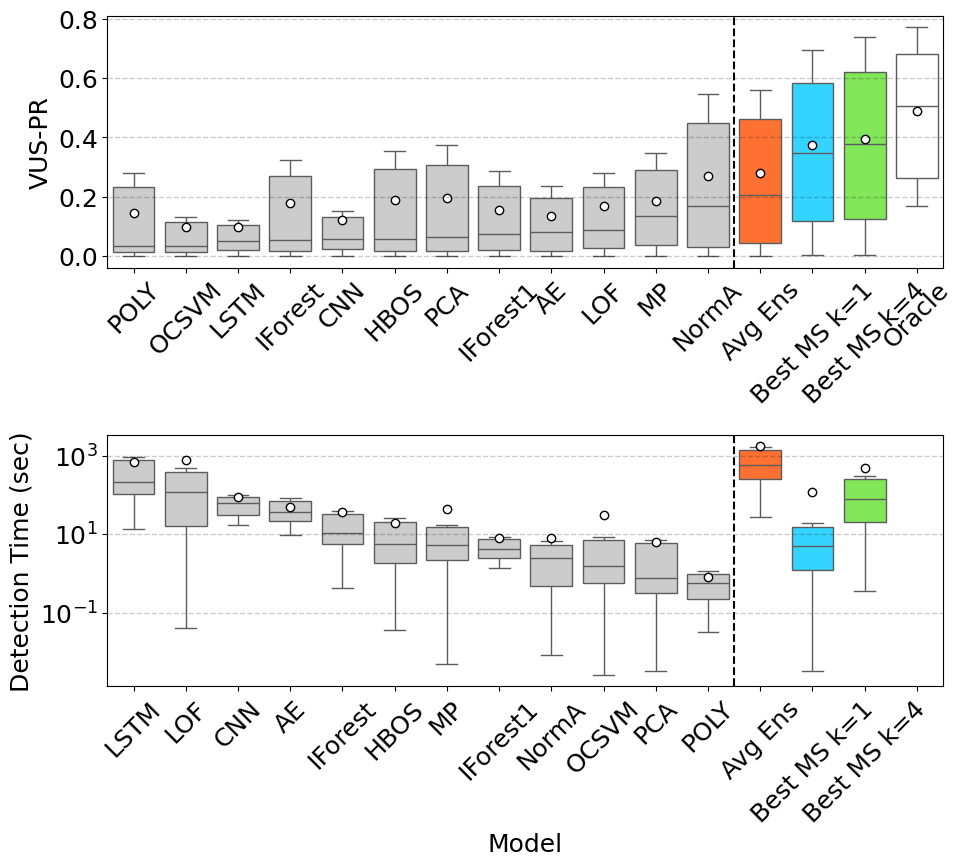

In [16]:
# Distinguish the models within the final df
ms_models = [x for x in df['Model'].unique() if any([y in x for y in model_selectors])]
msad_models = [x for x in ms_models if x.endswith('vote_1')]
msade_models = [x for x in ms_models if x not in msad_models]
rest_models = [x for x in df['Model'].unique() if not any([y in x for y in model_selectors])]

# Set up the figure
fig, ax = plt.subplots(2, 1, figsize=(10, 9))  # Adjust the figure size for a vertical boxplot

# Keep the models that we want to show here
model_medians = df.groupby('Model')[curr_metric].median().sort_values()
curr_models = rest_models + [model_medians[msad_models].idxmax(), model_medians[msade_models].idxmax()]
curr_df = df[df['Model'].isin(curr_models)]
sorted_models = [x for x in model_medians.index.tolist() if x in curr_models]

# Calculate median execution times for sorting the detectors in the second plot
detector_execution_time_medians = curr_df[curr_df['Model'].isin(detector_names)].groupby('Model')['Execution time'].median().sort_values(ascending=False)
sorted_detector_models = detector_execution_time_medians.index.tolist()
sorted_models_execution_time = sorted_detector_models + [model for model in sorted_models if model not in detector_names]

print(f"The best model is: {model_medians[msade_models].idxmax()}")

# Create accuracy plot
sns.boxplot(
    ax=ax[0],
    data=curr_df,
    y=curr_metric,
    x='Model',
    order=sorted_models,
    whis=0.241289844,
    showfliers=False,
    showmeans=True,
    meanprops=meanprops,
    palette=get_palette(model_colors, mode="best"),
    saturation=1,
    hue="Model",
)
ax[0].set_xlabel('')

# Create execution time plot
sns.boxplot(
    ax=ax[1],
    data=curr_df[curr_df['Model'] != 'TRUE_ORACLE-100'],
    y='Execution time',
    x='Model',
    order=sorted_models_execution_time,
    whis=0.241289844,
    showfliers=False,
    showmeans=True,
    meanprops=meanprops,
    palette=get_palette(model_colors, mode="best"),
    saturation=1,
    hue="Model",
)
ax[1].set_yscale('log')
ax[1].set_ylabel('Detection Time (sec)')

# Refine plot labels
for i, axis in enumerate(ax):
    locs, labels = axis.get_xticks(), axis.get_xticklabels()
    new_labels = refine_model_names(
        labels, 
        specific_map={
            model_medians[msad_models].idxmax(): 'Best MS k=1', 
            model_medians[msade_models].idxmax(): 'Best MS k=4',
            'TRUE_ORACLE-100': 'Oracle' if i == 0 else ''
        }
    )
    axis.set_xticks(locs, labels, rotation=45)

    axis.grid(axis='y', color='k', linestyle='--', linewidth=1, alpha=0.2)
    axis.set_axisbelow(False)
    axis.axvline(11.5, color='black', linestyle='--')

plt.tight_layout()
plt.savefig(os.path.join(save_fig_path, "Fig1.svg"))
plt.show()
plt.close()

## Figure 2: Accuracy of different detectors

In [17]:
# Read all timeseries and labels from 'raw'
timeseries = []

for dataset in tqdm(datasets):
    curr_files = os.listdir(os.path.join(raw_data_path, dataset))
    for file in curr_files:
        curr_timeseries = pd.read_csv(os.path.join(raw_data_path, dataset, file), header=None)
        timeseries.append({
            "Data": curr_timeseries[0].values,
            "Labels": curr_timeseries[1].values,
            "Dataset": dataset,
            "Filename": file,
        })
timeseries = pd.DataFrame(timeseries)

100%|███████████████████████████████████████████| 14/14 [00:19<00:00,  1.37s/it]


In [18]:
def plot_signal_with_anomalies(x, y, title=None, axis=None, subsequence_length=None, linewidth=1.3):
    if axis is None:
        _, axis = plt.subplots()
    
    # If subsequence_length is provided, select a subsequence with at least one anomaly
    if subsequence_length is not None and len(x) > subsequence_length:
        anomaly_indices = np.where(y == 1)[0]
        if len(anomaly_indices) > 0:
            # Choose a random anomaly index
            anomaly_index = np.random.choice(anomaly_indices)
            
            # Ensure the anomaly is within the subsequence
            start_index = max(0, min(anomaly_index - subsequence_length // 2, len(x) - subsequence_length))
            end_index = start_index + subsequence_length
            
            x = x[start_index:end_index]
            y = y[start_index:end_index]
        else:
            # If no anomalies, just take a random subsequence
            start_index = np.random.randint(0, len(x) - subsequence_length)
            end_index = start_index + subsequence_length
            x = x[start_index:end_index]
            y = y[start_index:end_index]
    
    axis.plot(x, linewidth=linewidth)
    axis.set_xlim(0, len(x))
    
    holder = None
    for i in range(len(y)):
        if y[i] == 1 and holder is None:
            holder = max(0, i-1)
        elif y[i] == 0 and holder:
            axis.plot(np.arange(holder, i+1), x[holder:i+1], color='red', linewidth=linewidth)
            holder = None
            i += 1
            
    # In case the anomaly extends to the end of the sequence
    if holder:  
        axis.plot(np.arange(holder, len(y)), x[holder:], color='red')
    
    if title:
        axis.set_title(title)

In [19]:
def create_fig2():
    # Plot 4 subsequences from 4 different datasets along with the detectors' scores per dataset
    curr_datasets = [('ECG', 3), ('MGAB', 6), ('Daphnet', 8), ('YAHOO', 242)]
    letters = ['a', 'b', 'c', 'd']    # this is very specific to this plot :P
    fig, ax = plt.subplots(4, 2, figsize=(14, 13))
    detectors_scores = full_df[full_df["Model"].isin(detector_names)]
    boxplot_margin = 0.03
    
    for i, (dataset, tmp_index) in enumerate(curr_datasets):
        tmp_df = timeseries[timeseries['Dataset'] == dataset]
        if tmp_index is None: tmp_index = np.random.randint(0, len(tmp_df), 1)[0]
        print(f"For {dataset} selected index {tmp_index}")
        
        random_timeseries = tmp_df.iloc[tmp_index]
        plot_signal_with_anomalies(
            random_timeseries['Data'], 
            random_timeseries['Labels'], 
            title=f"({letters[i]}.1) Example from {dataset} dataset", 
            axis=ax[i, 0],
            subsequence_length=1500,
        )
        ax[i, 0].set_xticks([])
        ax[i, 0].set_yticks([])
    
        curr_detector_scores = detectors_scores[detectors_scores['Dataset'] == dataset]
        best_detector = curr_detector_scores.groupby('Model')["AUC-PR"].median().idxmax()
        
        sns.boxplot(
            ax=ax[i, 1], 
            data=curr_detector_scores, 
            x='Model', 
            y='AUC-PR', 
            color='#CCCCCC', 
            saturation=1
        )
        ax[i, 1].set_yticks(np.linspace(0, 1, 6))
        ax[i, 1].set_ylim(0 - (2 * boxplot_margin), 1 + (2 * boxplot_margin))
        ax[i, 1].set_title(f"({letters[i]}.2) {dataset} best detector: {model_name_map[best_detector]}")
        [ax[i, j].set_xlabel('') for j in range(2)]
        if i == (len(curr_datasets) - 1):
            locs, labels = ax[i, 1].get_xticks(), ax[i, 1].get_xticklabels()
            ax[i, 1].set_xticks(locs, refine_model_names(labels), rotation=45)
        else:
            ax[i, 1].set_xticks([])

        # Highlight the boxplot with the highest median
        best_detector_index = list(curr_detector_scores['Model'].unique()).index(best_detector)
        highlight = plt.Rectangle(
            (best_detector_index-0.5, 0), 
            width=1, 
            height=1 + boxplot_margin,
            fill=True, 
            facecolor='#FFFFC5', 
            alpha=1, 
            linestyle='--', 
            edgecolor='black',
            linewidth=1.3,
        )
        ax[i, 1].add_patch(highlight)
    
    plt.tight_layout()
    plt.subplots_adjust(wspace=.135, hspace=.15)
    plt.savefig(os.path.join(save_fig_path, "Fig2.svg"), bbox_inches='tight')
    plt.show()
    plt.close()

For ECG selected index 3
For MGAB selected index 6
For Daphnet selected index 8
For YAHOO selected index 242


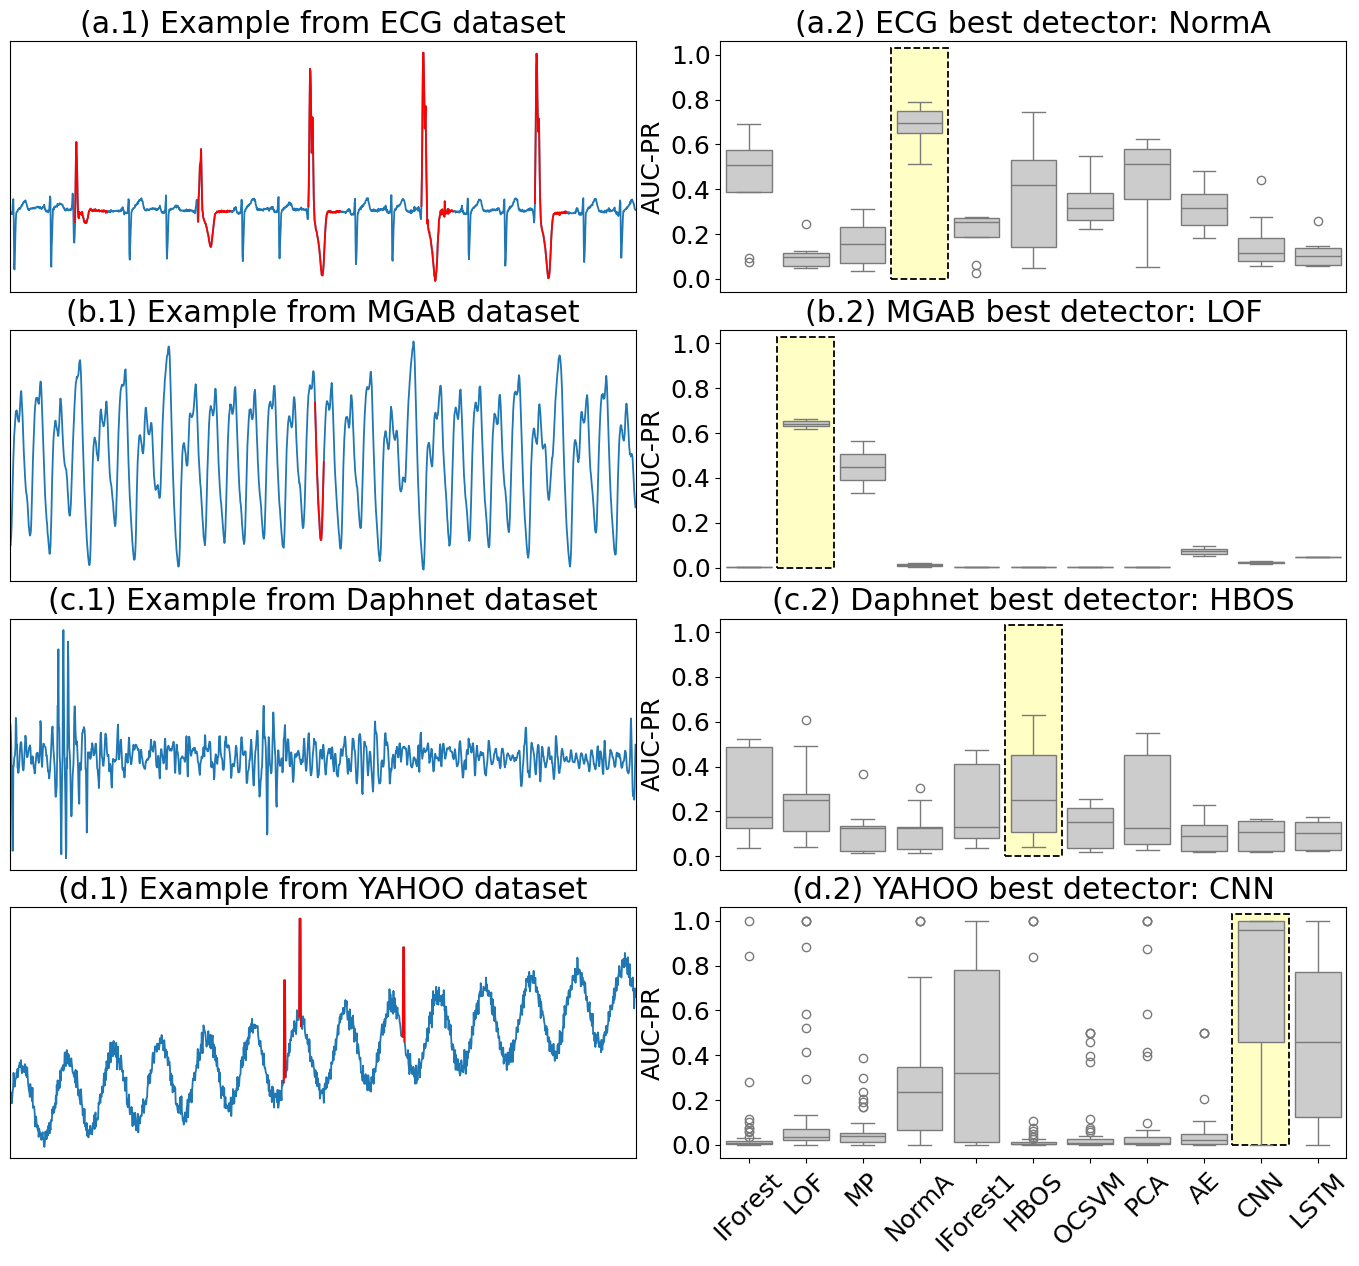

In [20]:
create_fig2()

## Figure 3: Pipeline

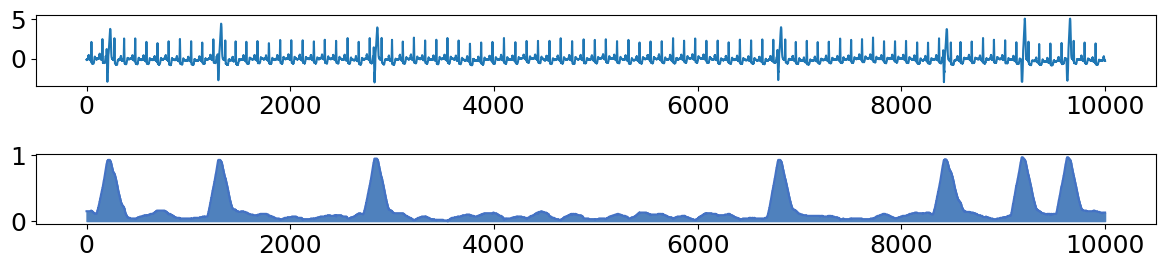

In [21]:
timeseries_data = pd.read_csv(os.path.join(raw_data_path, 'ECG', 'MBA_ECG805_data.out'), header=None)
score = pd.read_csv(os.path.join(scores_path, 'ECG', 'NORMA', 'score', 'MBA_ECG805_data.out'), header=None).values.flatten()

x = timeseries_data[0].values
y = timeseries_data[1].values
start = 50000
stop = 60000

fig, axes = plt.subplots(2, 1, figsize=(12, 3))
sns.lineplot(ax=axes[0], data=x[start:stop], color='#1F77B4')
sns.lineplot(ax=axes[1], data=score[start:stop], color='#4472C4')
plt.fill_between(np.arange(stop-start), score[start:stop], color='#4F81BD')

plt.tight_layout()
plt.savefig(os.path.join(save_fig_path, "Fig3.svg"))
plt.show()
plt.close()

## Figure 5: Overall results

In [22]:
# Keep the models we want to show, detectors, avg ens, oracle, msad best per family, msade best per family
msade_models = [x for x in full_df['Model'].unique() if ('vote' in x) or ('average' in x)]
msad_models = [x for x in full_df['Model'].unique() if (x not in msade_models + detector_names + ['Avg Ens', 'Oracle'])]
msad_families = set(["_".join(x.split('_')[:-1]) for x in msad_models])
msade_families = set(["_".join(x.split('_')[:-1]) for x in msade_models])

# Sort models by performance
sorted_msad_models = full_df[full_df['Model'].isin(msad_models)].groupby('Model')[curr_metric].median().sort_values(ascending=False)

# Find the best model for each family
best_msad_family_models = []
for family in msad_families:
    family_models = [model for model in sorted_msad_models.index if family in model]
    if family_models:
        best_msad_family_models.append(family_models[0])

# Sort models by performance
sorted_msade_models = full_df[full_df['Model'].isin(msade_models)].groupby('Model')[curr_metric].median().sort_values(ascending=False)

# Find the best model for each family
best_msade_family_models = []
for family in msade_families:
    family_models = [model for model in sorted_msade_models.index if family in model]
    if family_models:
        best_msade_family_models.append(family_models[0])

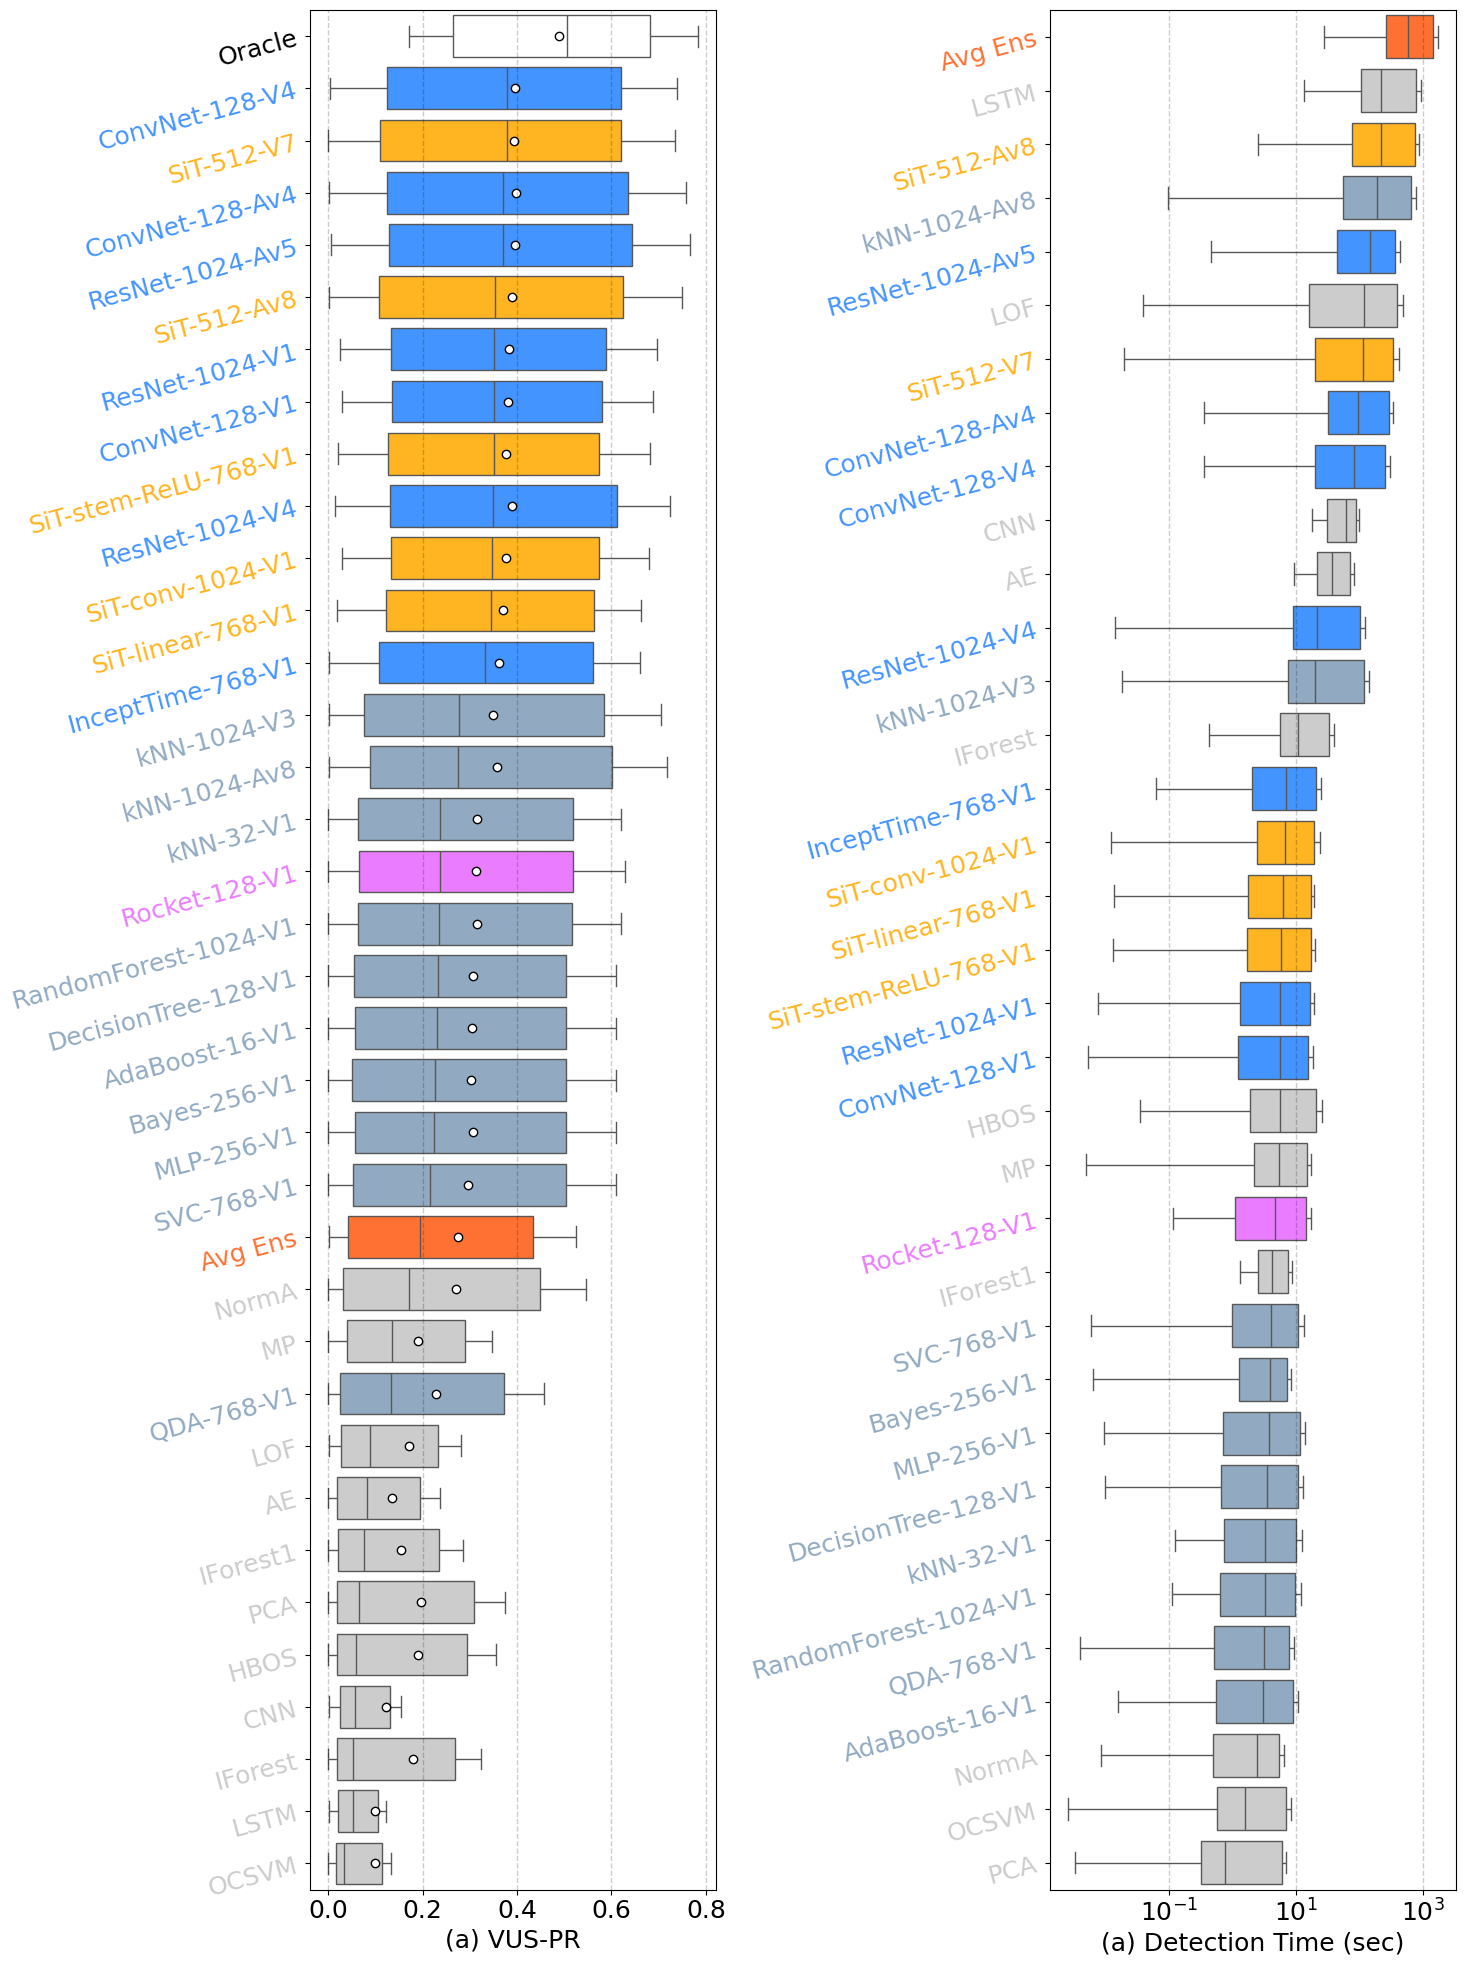

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(15, 20))

# Sort for anomaly accuracy
curr_models = best_msade_family_models + best_msad_family_models + detector_names + ['Avg Ens', 'Oracle']
model_medians = full_df[full_df['Model'].isin(curr_models)].groupby('Model')[curr_metric].median().sort_values(ascending=False)
sorted_models = [x for x in model_medians.index.tolist()]

# Sort for Execution time
curr_models = best_msade_family_models + best_msad_family_models + detector_names + ['Avg Ens']
model_medians = full_df[full_df['Model'].isin(curr_models)].groupby('Model')['Execution time'].median().sort_values(ascending=False)
sorted_models_execution_time = [x for x in model_medians.index.tolist()]

# Get current color palette
curr_palette = get_palette_new(full_df['Model'].unique())

sns.boxplot(
    ax=ax[0],
    data=full_df,
    y='Model',
    x=curr_metric,
    order=sorted_models,
    whis=0.241289844,
    showfliers=False,
    showmeans=True,
    meanprops=meanprops,
    palette=curr_palette,
    saturation=1,
    hue='Model',
)
ax[0].set_xlabel(f'(a) {curr_metric}')

sns.boxplot(
    ax=ax[1],
    data=full_df,
    y='Model',
    x='Execution time',
    order=sorted_models_execution_time,
    whis=0.241289844,
    showfliers=False,
    showmeans=False,
    palette=curr_palette,
    saturation=1,
    hue='Model',
)
ax[1].set_xscale('log')
ax[1].set_xlabel('(a) Detection Time (sec)')

# Refine plot labels
for i, axis in enumerate(ax):  
    locs, labels = axis.get_yticks(), axis.get_yticklabels()

    # Set yticks color
    for label in labels:
        if label.get_text().lower() == 'oracle':
            label.set_color('#000000')
        else:
            label.set_color(curr_palette[label.get_text()])
    
    new_labels = refine_model_names(labels)
    axis.set_yticks(locs, labels, rotation=15)
    axis.set_ylabel('')
    axis.grid(axis='x', color='k', linestyle='--', linewidth=1, alpha=0.2)
    axis.set_axisbelow(False)

plt.tight_layout()
plt.savefig(os.path.join(save_fig_path, "Fig5.svg"))
plt.show()
plt.close()

## Figure 6: Distribution of selected detectors

In [24]:
curr_model_selectors = ['label', 'resnet1024', 'convnet128', 'sit512', 'knn1024']

# Keep only the 'MSAD-E' model selectors and only for k = 1
curr_df = results_df[results_df['Model Selector'].isin(curr_model_selectors) & (results_df['k'] == 1)].copy()

# Create the 'Predicted class' column out of the weights
curr_df['Predicted class'] = curr_df[weight_names].apply(lambda x: (x == 1).idxmax().replace('weight_', ''), axis=1)

# Add label to the model selector column to include it to the histplot
curr_label_df = label_df.melt(id_vars='Time series', var_name='Model Selector', value_name='Predicted class')
curr_vote_df = pd.concat([curr_df[curr_df['Combine Method'] == 'vote'][['Time series', 'Model Selector', 'Predicted class']], curr_label_df])
curr_average_df = pd.concat([curr_df[curr_df['Combine Method'] == 'average'][['Time series', 'Model Selector', 'Predicted class']], curr_label_df])

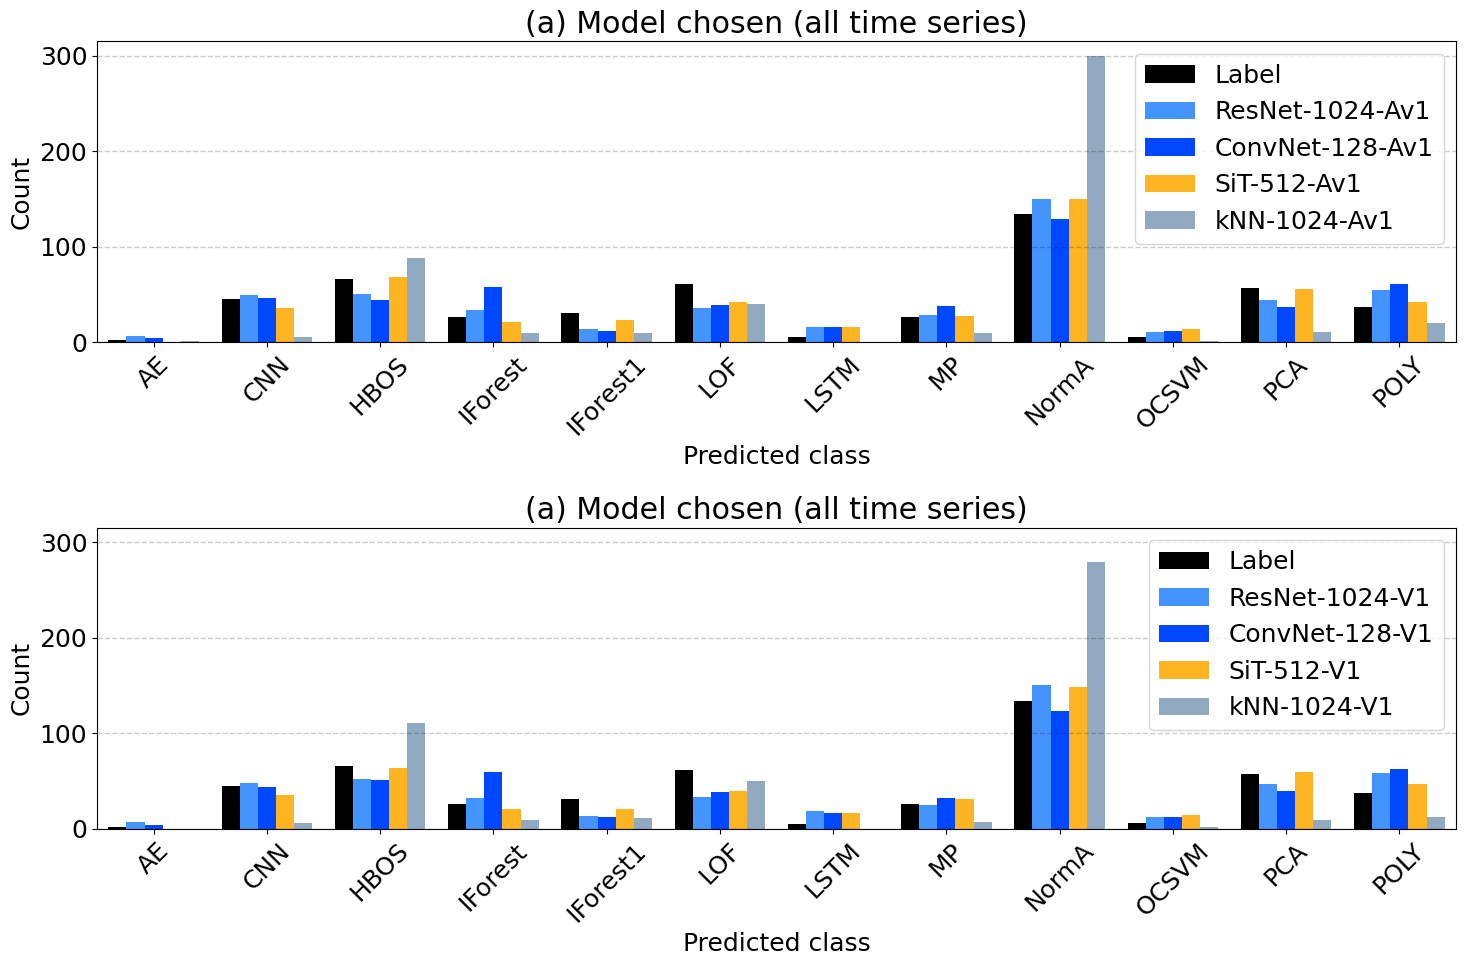

In [25]:
fix, axes = plt.subplots(2, 1, figsize=(15, 10), sharey=True)

# Get current palette for this specific plot
curr_palette = get_palette_new(curr_model_selectors, {'convnet128': 'conv_2'})

# Plot for average method
sns.countplot(
    x='Predicted class', 
    hue='Model Selector', 
    data=curr_average_df,
    order=detector_names, 
    saturation=1, 
    hue_order=curr_model_selectors,
    ax=axes[0],
    palette=curr_palette,
)
axes[0].set_xlabel('')
axes[0].set_title('(a) Model chosen (all time series)')

# Plot for vote method
sns.countplot(
    x='Predicted class', 
    hue='Model Selector', 
    data=curr_vote_df, 
    order=detector_names, 
    saturation=1, 
    hue_order=curr_model_selectors,
    ax=axes[1],
    palette=curr_palette,
)
axes[1].set_title('(a) Model chosen (all time series)')
axes[1].tick_params(axis='x', labelrotation=45)

# Changes for both
for ax in axes:
    ax.grid(axis='y', color='k', linestyle='--', linewidth=1, alpha=0.2)
    ax.set_ylabel('Count')
    ax.set_xlabel('Predicted class')
    ax.set_xticks(ax.get_xticks(), refine_model_names(ax.get_xticklabels()), rotation=45)

# Fix names for camera-ready
axes[0].legend(labels=refine_model_names([f"{x}_average_1" if i > 0 else x for i, x in enumerate(curr_model_selectors)]))
axes[1].legend(labels=refine_model_names([f"{x}_vote_1" if i > 0 else x for i, x in enumerate(curr_model_selectors)]))

plt.tight_layout()
plt.savefig(os.path.join(save_fig_path, "Fig6_a.svg"))
plt.show()
plt.close()

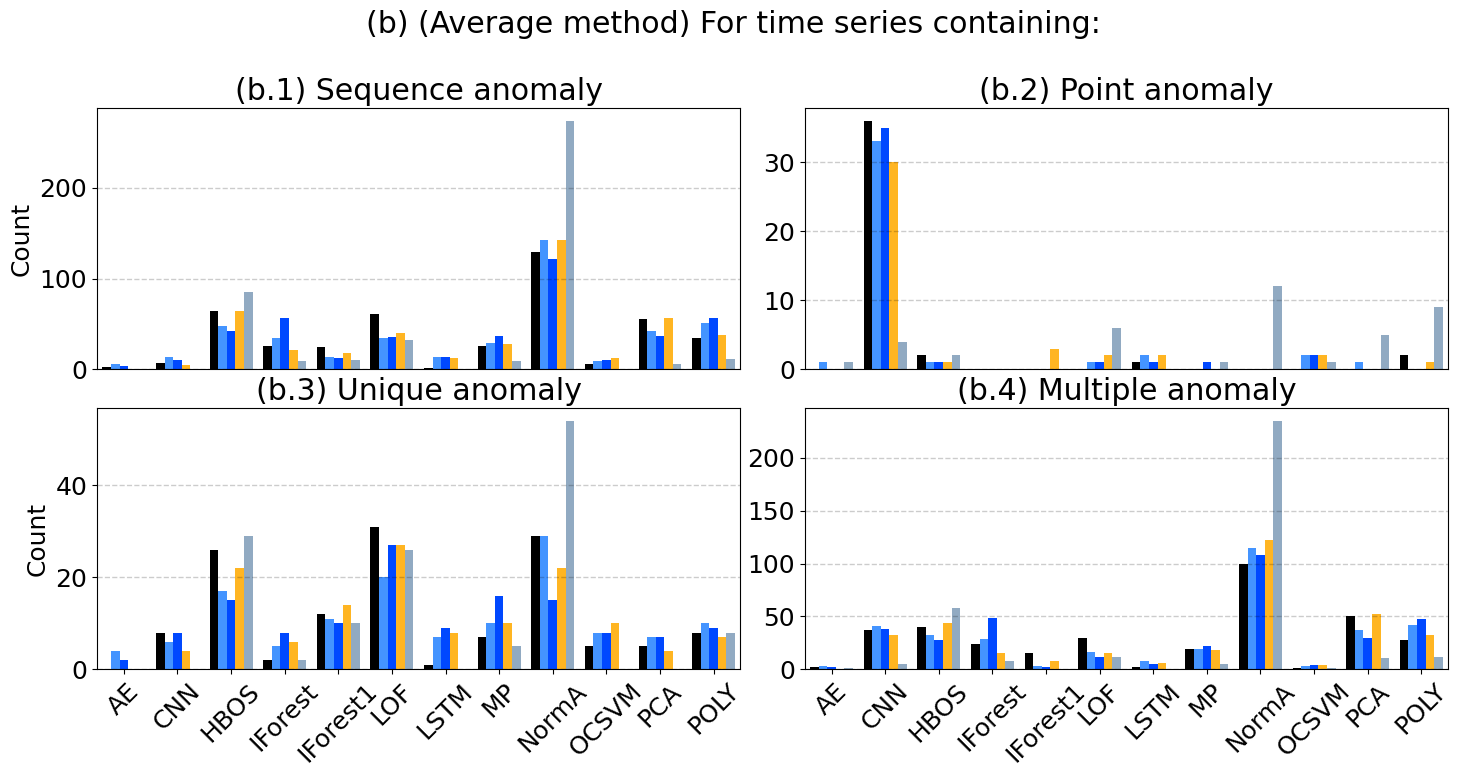

In [26]:
fix, axes = plt.subplots(2, 2, figsize=(15, 8))
letters = ['a', 'b', 'c', 'd']
curr_subplots = [{
    "title": "Sequence anomaly",
    "index": charac_df[charac_df['seq_anom'] == 1].index,
}, {
    "title": "Point anomaly",
    "index": charac_df[charac_df['point_anom'] == 1].index,
}, {
    "title": "Unique anomaly",
    "index": charac_df[charac_df['nb_anomaly'] == 1].index,
}, {
    "title": "Multiple anomaly",
    "index": charac_df[charac_df['nb_anomaly'] > 1].index,
}]

# Plot
for i, (elem) in enumerate(curr_subplots):
    sns.countplot(
        x='Predicted class', 
        hue='Model Selector', 
        data=curr_average_df[curr_average_df['Time series'].isin(elem['index'])],
        order=detector_names, 
        saturation=1, 
        hue_order=curr_model_selectors,
        ax=axes[i//2, i % 2],
        palette=curr_palette,
    )
    axes[i//2, i % 2].get_legend().remove()
    axes[i//2, i % 2].tick_params(axis='x', labelrotation=50)
    axes[i//2, i % 2].set_xlabel('')
    axes[i//2, i % 2].grid(axis='y', color='k', linestyle='--', linewidth=1, alpha=0.2)
    axes[i//2, i % 2].set_title(f"(b.{i + 1}) {elem['title']}")
    axes[i//2, i % 2].set_ylabel('Count') if not i % 2 else axes[i//2, i % 2].set_ylabel('') 
    if i < 2:
        axes[i//2, i % 2].set_xticks([])
    else:
        axes[i//2, i % 2].set_xticks(axes[i//2, i % 2].get_xticks(), refine_model_names(axes[i//2, i % 2].get_xticklabels()), rotation=45)


plt.suptitle('(b) (Average method) For time series containing:')
plt.tight_layout()
plt.subplots_adjust(wspace=.1, hspace=.15)
plt.savefig(os.path.join(save_fig_path, "Fig6_b1.svg"))
plt.show()
plt.close()

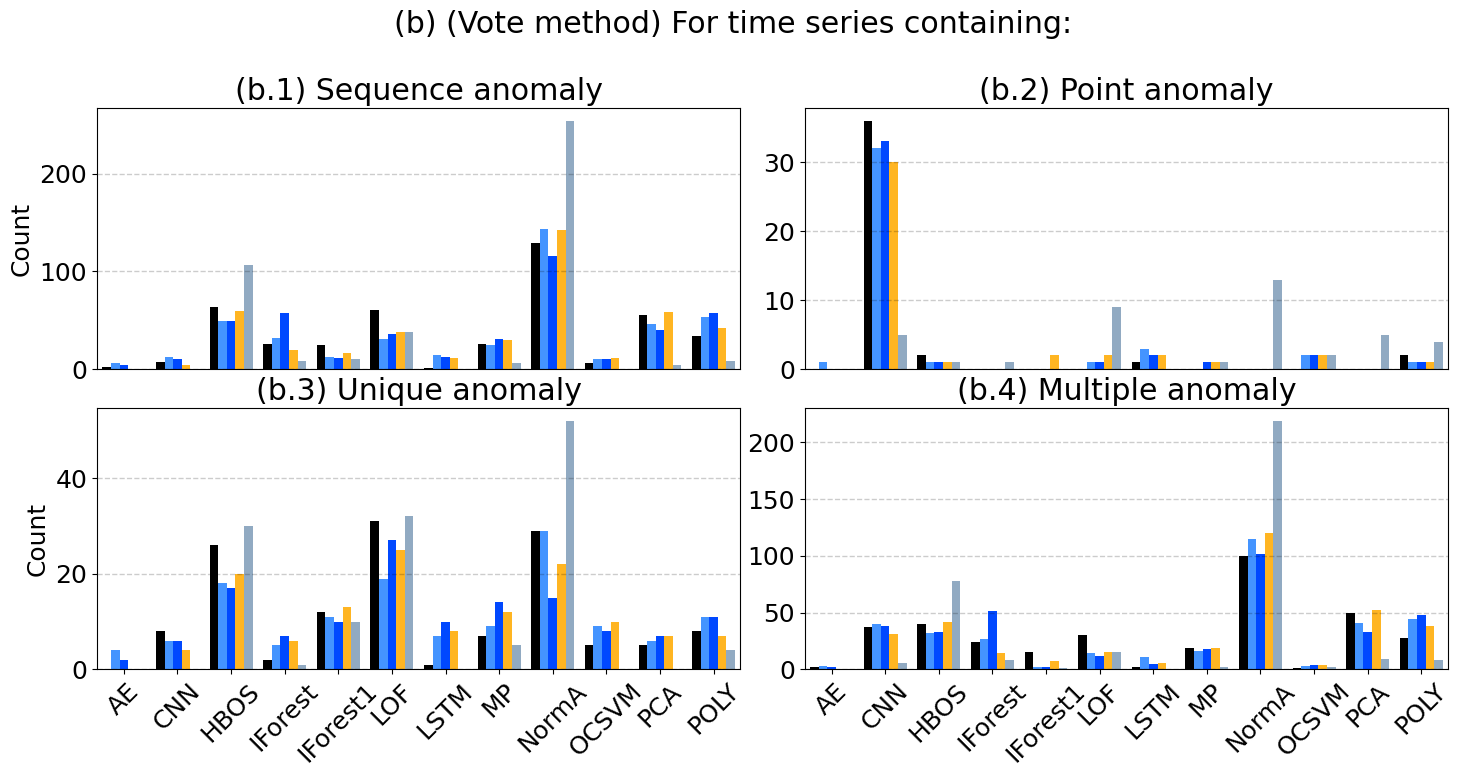

In [27]:
fix, axes = plt.subplots(2, 2, figsize=(15, 8))

# Plot
for i, (elem) in enumerate(curr_subplots):
    sns.countplot(
        x='Predicted class', 
        hue='Model Selector', 
        data=curr_vote_df[curr_vote_df['Time series'].isin(elem['index'])],
        order=detector_names, 
        saturation=1, 
        hue_order=curr_model_selectors,
        ax=axes[i//2, i % 2],
        palette=curr_palette,
    )
    axes[i//2, i % 2].get_legend().remove() 
    axes[i//2, i % 2].tick_params(axis='x', labelrotation=50)
    axes[i//2, i % 2].set_xlabel('')
    axes[i//2, i % 2].grid(axis='y', color='k', linestyle='--', linewidth=1, alpha=0.2)
    axes[i//2, i % 2].set_title(f"(b.{i + 1}) {elem['title']}")
    axes[i//2, i % 2].set_ylabel('Count') if not i % 2 else axes[i//2, i % 2].set_ylabel('') 
    if i < 2:
        axes[i//2, i % 2].set_xticks([])
    else:
        axes[i//2, i % 2].set_xticks(axes[i//2, i % 2].get_xticks(), refine_model_names(axes[i//2, i % 2].get_xticklabels()), rotation=45)

plt.suptitle('(b) (Vote method) For time series containing:')
plt.tight_layout()
plt.subplots_adjust(wspace=.1, hspace=.15)
plt.savefig(os.path.join(save_fig_path, "Fig6_b2.svg"))
plt.show()
plt.close()

## Figure 7: Detection time vs Time series length

In [28]:
timeseries['length'] = timeseries['Data'].apply(lambda x: len(x))
timeseries['Time series'] = timeseries.apply(lambda x: f"{x['Dataset']}/{x['Filename']}", axis=1)
timeseries.set_index('Time series', inplace=True)

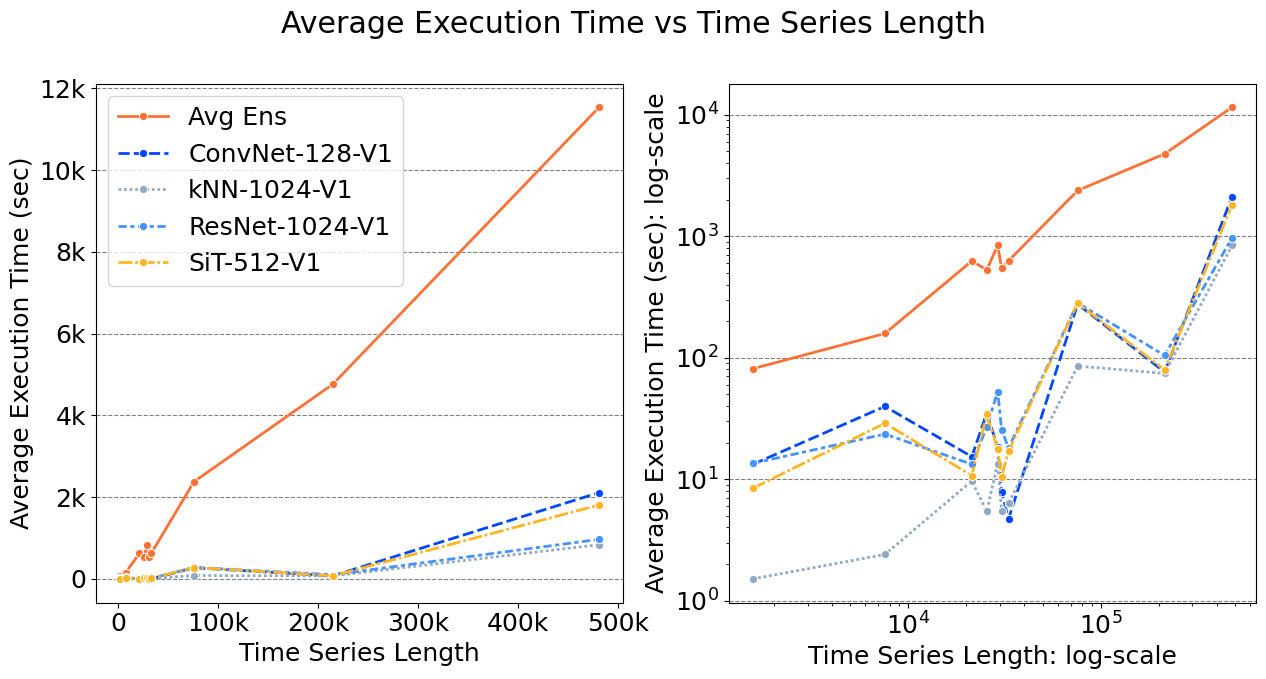

In [29]:
curr_models = ['resnet1024', 'convnet128', 'sit512', 'knn1024']

# Average and vote are similar, uncomment below to see
curr_models = ['AVG_ENS'] + [f"{x}_vote_1" for x in curr_models]# + [f"{x}_average_1" for x in curr_models]
num_bins = 10

# Get current palette for this specific plot
curr_palette = get_palette_new(curr_models, {'convnet128_vote_1': 'conv_2', 'convnet128_average_1': 'conv_2'})

curr_df = df[df['Model'].isin(curr_models) | (df['Model'] == 'AVG_ENS')].copy()
curr_df['length'] = curr_df.apply(lambda x: timeseries.loc[x['Time series']]['length'], axis=1)
curr_df['length_bin'] = pd.qcut(curr_df['length'], q=num_bins, labels=False)  # Quantile-based bins
# bins = np.linspace(start=0, stop=curr_df['length'].max(), num=num_bins)     # Equal-length bins
# curr_df['length_bin'] = pd.cut(curr_df['length'], bins=bins, labels=bins[:-1])

# Group by binned length and model, and calculate the mean execution time
summary_df = curr_df.groupby(['length_bin', 'Model'], observed=False)['Execution time'].mean().reset_index()
length_bin_centers = curr_df.groupby('length_bin', observed=False)['length'].mean().reset_index()
summary_df = summary_df.merge(length_bin_centers, on='length_bin')

# Plot
fig, ax = plt.subplots(1, 2, figsize=(13, 7))

# Plot the average execution time for each model at different bin centers
sns.lineplot(data=summary_df, x='length', y='Execution time', hue='Model', marker='o', style='Model', ax=ax[0], palette=curr_palette, linewidth=2)
ax[0].set_xlabel('Time Series Length')
ax[0].set_ylabel('Average Execution Time (sec)')
ax[0].grid(color='gray', linestyle='--', axis='y')
ax[0].set_xticks(ax[0].get_xticks()[1:-1], [f"{int(x // 1000)}k" if x > 1000 else int() for x in ax[0].get_xticks()][1:-1])
ax[0].set_yticks(ax[0].get_yticks()[1:-1], [f"{int(x // 1000)}k" if x > 1000 else int() for x in ax[0].get_yticks()][1:-1])
[x.set_text(refine_model_names([x.get_text()])[0]) for x in ax[0].legend().get_texts()]

sns.lineplot(data=summary_df, x='length', y='Execution time', hue='Model', marker='o', style='Model', ax=ax[1], palette=curr_palette, linewidth=2)
ax[1].set_xlabel('Time Series Length: log-scale')
ax[1].set_ylabel('Average Execution Time (sec): log-scale')
ax[1].grid(color='gray', linestyle='--', axis='y')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].get_legend().remove()

plt.suptitle('Average Execution Time vs Time Series Length')
plt.tight_layout()
plt.subplots_adjust(wspace=.2)
plt.savefig(os.path.join(save_fig_path, "Fig7.svg"))
plt.show()
plt.close()

## Figure 8: Window length analysis

In [30]:
# Set up the dataframes we will use for the next plot
detectors_df = old_results_df[old_results_df['Model'].isin(detector_names)]
avg_ens_df = old_results_df[old_results_df['Model'] == 'Avg Ens']
oracle_df = old_results_df[old_results_df['Model'] == 'Oracle']
curr_df = old_results_df[~(old_results_df['Model'].isin(detector_names) | (old_results_df['Model'] == 'Avg Ens') | (old_results_df['Model'] == 'Oracle'))].copy()
curr_df['Window length'] = curr_df['Model'].apply(lambda x: int(x.split('_')[-1]))
curr_df['Model family'] = curr_df['Model'].apply(lambda x: group_models(x))

# Set up label for classification accuracy
curr_df['Label'] = curr_df['Time series'].apply(lambda x: label_df[label_df['Time series'] == x]['label'].iloc[0])

# Set up selection time
selection_time_df.columns = [re.sub(r'_pred$', '', x) for x in selection_time_df.columns]
curr_selection_time_df = selection_time_df.melt(id_vars='Time series', var_name='Model', value_name='Selection time')
curr_selection_time_df['Model family'] = curr_selection_time_df['Model'].apply(lambda x: group_models(x))
curr_selection_time_df['Window length'] = curr_selection_time_df['Model'].apply(lambda x: int(x.split('_')[-1]))

# Compute accuracy per Model family
curr_df['Correct'] = curr_df['Predicted class'] == curr_df['Label']
accuracy_df = curr_df.groupby(['Model family', 'Window length'])['Correct'].agg(Total='count', Correct='sum').reset_index()
accuracy_df['Classification accuracy'] = accuracy_df['Correct'] / accuracy_df['Total']

# Set up training time
avg_training_time_df = training_time_df.rename(columns={
    'window_size': 'Window length',
    'rocket': 'Rocket',
    'conv_based (avg)': 'Convolutional-based', 
    'tranformer_based (avg)': 'Transformer-based', 
    'feature_based (avg)': 'Feature-based'
})
avg_training_time_df = avg_training_time_df[['Window length', 'Rocket', 'Convolutional-based', 'Transformer-based', 'Feature-based']]
avg_training_time_df = avg_training_time_df.melt(id_vars='Window length', var_name='Model family', value_name='Training time')

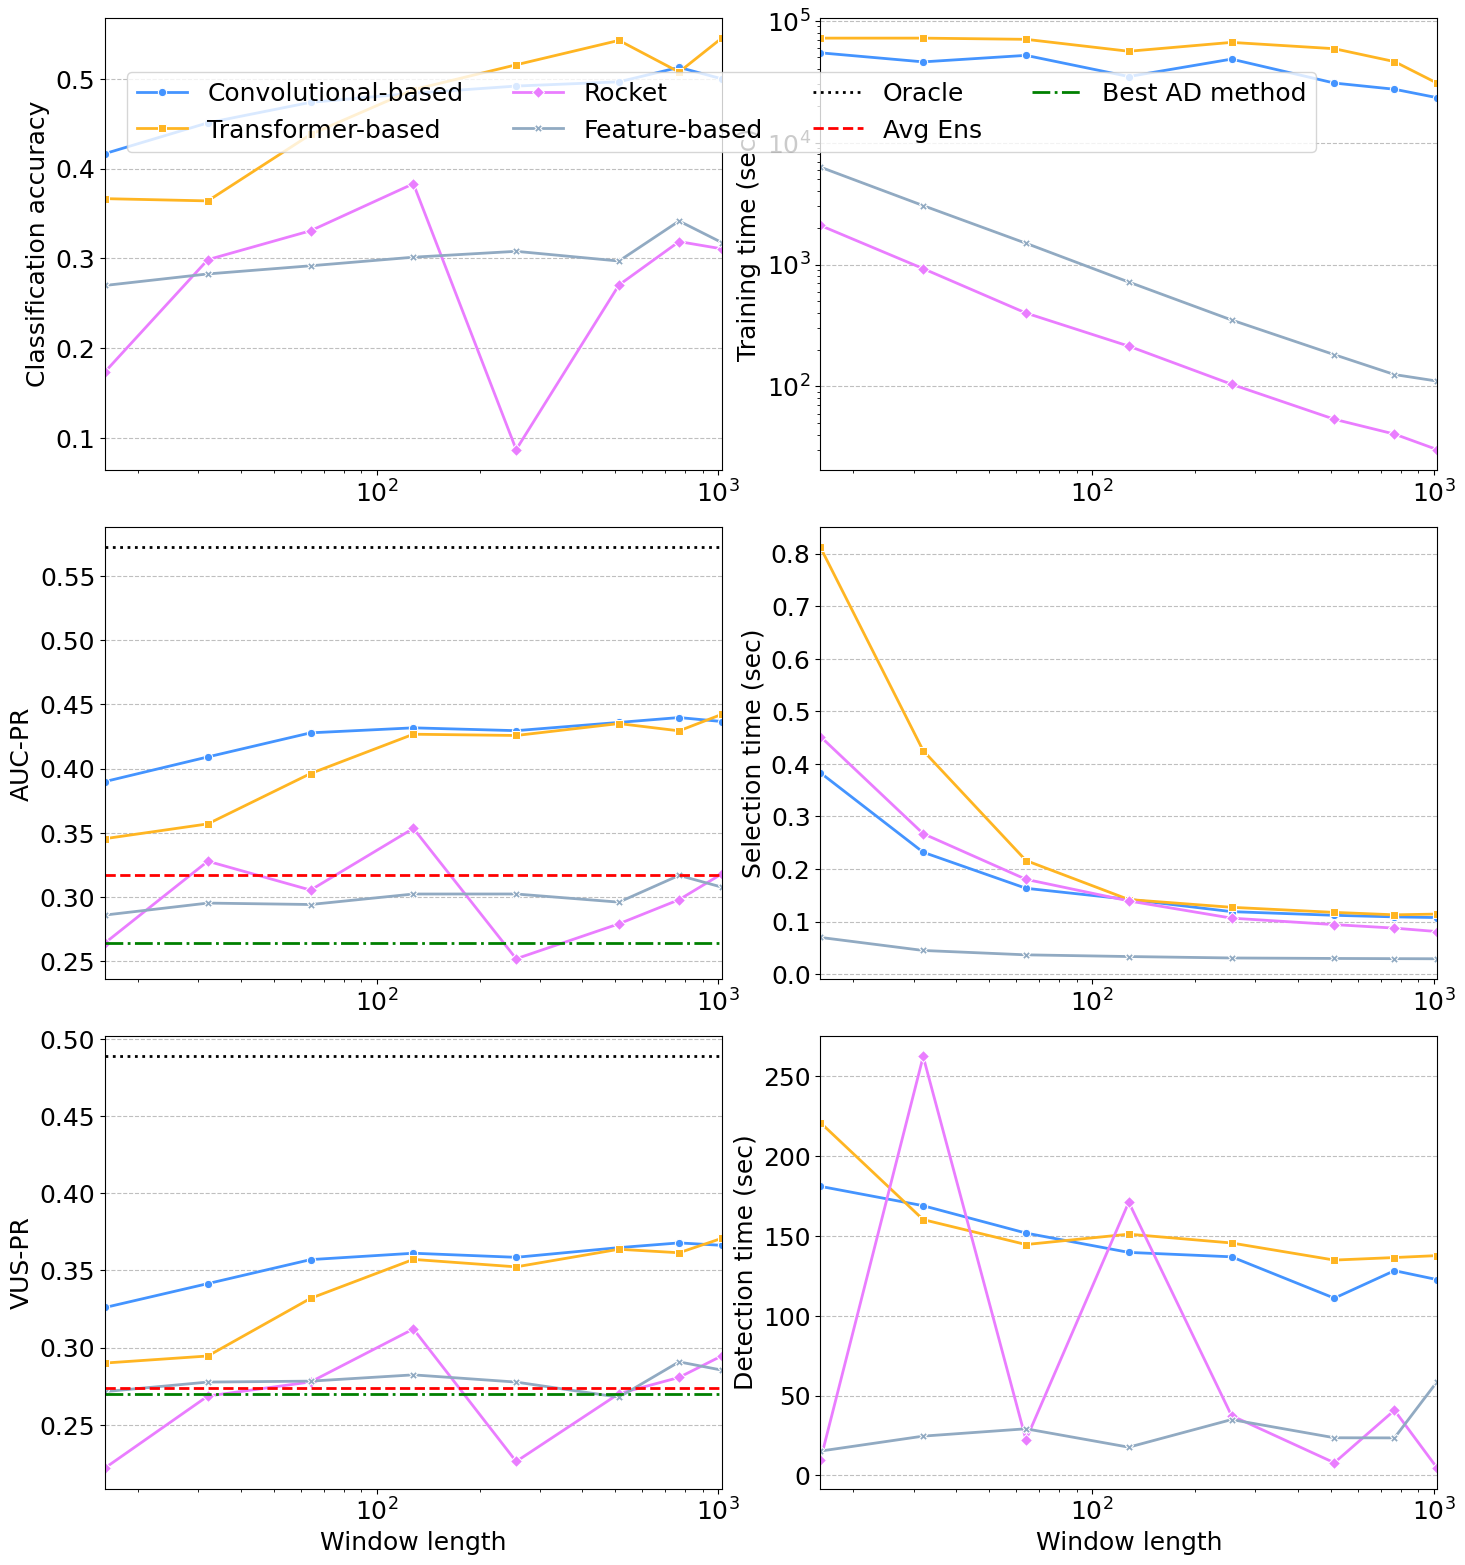

In [31]:
fig, ax = plt.subplots(3, 2, figsize=(15, 16))
hue_order = ['Convolutional-based', 'Transformer-based', 'Rocket', 'Feature-based']
errorbar = None # “ci”, “pi”, “se”, “sd” or None
markers_dict = {
    'Convolutional-based': 'o',   # Circle
    'Transformer-based': 's',     # Square
    'Rocket': 'D',                # Diamond
    'Feature-based': 'X'          # X shape
}
curr_palette = get_palette_new(hue_order)

# Plot class. acc.
sns.lineplot(
    data=accuracy_df, 
    x='Window length', 
    y='Classification accuracy', 
    hue='Model family', 
    ax=ax[0, 0], 
    style='Model family',
    dashes=False,
    linewidth=2, 
    markers=markers_dict, 
    hue_order=hue_order, 
    errorbar=errorbar,
    palette=curr_palette,
)

# Plot AUC
sns.lineplot(
    data=curr_df, 
    x='Window length', 
    y='AUC-PR', 
    hue='Model family', 
    ax=ax[1, 0],
    style='Model family',
    dashes=False,
    linewidth=2, 
    markers=markers_dict, 
    hue_order=hue_order,
    errorbar=errorbar,
    palette=curr_palette,
)
ax[1, 0].axhline(y=oracle_df['AUC-PR'].mean(), color='k', linestyle='dotted', linewidth=2, label='Oracle')
ax[1, 0].axhline(y=avg_ens_df['AUC-PR'].mean(), color='red', linestyle='--', linewidth=2, label='Avg Ens')
ax[1, 0].axhline(y=detectors_df.groupby('Model')['AUC-PR'].mean().max(), color='green', linestyle='-.', linewidth=2, label='Best AD method')
ax[1, 0].legend()

# Plot VUS
sns.lineplot(
    data=curr_df,
    x='Window length', 
    y='VUS-PR', 
    hue='Model family', 
    ax=ax[2, 0],
    style='Model family',
    dashes=False,
    linewidth=2,
    markers=markers_dict, 
    hue_order=hue_order,
    errorbar=errorbar,
    palette=curr_palette,
)
ax[2, 0].axhline(y=oracle_df['VUS-PR'].mean(), color='k', linestyle='dotted', linewidth=2)
ax[2, 0].axhline(y=avg_ens_df['VUS-PR'].mean(), color='red', linestyle='--', linewidth=2)
ax[2, 0].axhline(y=detectors_df.groupby('Model')['VUS-PR'].mean().max(), color='green', linestyle='-.', linewidth=2)

# Plot Training time
sns.lineplot(
    data=avg_training_time_df, 
    x='Window length', 
    y='Training time', 
    hue='Model family', 
    ax=ax[0, 1],
    style='Model family',
    dashes=False,
    linewidth=2, 
    markers=markers_dict, 
    hue_order=hue_order,
    errorbar=errorbar,
    palette=curr_palette,
)
ax[0, 1].set_yscale('log')
ax[0, 1].set_ylabel('Training time (sec)')

# Plot Selection time
sns.lineplot(
    data=curr_selection_time_df, 
    x='Window length',
    y='Selection time', 
    hue='Model family', 
    ax=ax[1, 1],
    style='Model family',
    dashes=False,
    linewidth=2, 
    markers=markers_dict, 
    hue_order=hue_order,
    errorbar=errorbar,
    palette=curr_palette,
)
ax[1, 1].set_ylabel('Selection time (sec)')

# Plot Detection time
sns.lineplot(
    data=curr_df, 
    x='Window length',
    y='Detection time', 
    hue='Model family', 
    ax=ax[2, 1],
    style='Model family',
    dashes=False,
    linewidth=2, 
    markers=markers_dict, 
    hue_order=hue_order,
    errorbar=errorbar,
    palette=curr_palette,
)
ax[2, 1].set_ylabel('Detection time (sec)')

for i, axis in enumerate(ax.flatten()):
    if i != 2: 
        axis.get_legend().remove()
    if i < 4:
        axis.set_xlabel('')
    axis.set_xscale('log')
    axis.set_xlim(min(all_length), max(all_length))
    axis.grid(color='gray', linestyle='--', axis='y', alpha=0.5)

sns.move_legend(
    ax[1, 0], "lower center",
    bbox_to_anchor=(1, 1.8), ncol=4, title=None, frameon=True,
)

plt.tight_layout()
plt.subplots_adjust(wspace=.16, hspace=.125)
plt.savefig(os.path.join(save_fig_path, "Fig8.svg"))
plt.show()
plt.close()

## Figure 9: Correllation

Get from MSAD repo, this one is not complete.

In [98]:
characteristics = ['length', 'average_anom_length', 'nb_anomaly', 'ratio']

# Set up the dataframe for this plot
charac_df['dataset'] = charac_df.apply(lambda x: x.name.split('/')[0], axis=1)
charac_df['length'] = charac_df.apply(lambda x: timeseries.loc[x.name]['length'], axis=1)

curr_df = old_results_df[~(old_results_df['Model'].isin(detector_names) | (old_results_df['Model'] == 'Avg Ens') | (old_results_df['Model'] == 'Oracle'))].copy()
curr_df[characteristics] = curr_df['Time series'].apply(lambda x: charac_df.loc[x][characteristics])

curr_df['Window length'] = curr_df['Model'].apply(lambda x: int(x.split('_')[-1]))
curr_df['Model family'] = curr_df['Model'].apply(lambda x: group_models(x))

In [110]:
avg_chara_df = curr_df.groupby('Dataset')[characteristics].mean()

length  average_anom_length  nb_anomaly     ratio
Dataset                                                              
Daphnet       21266.692308           448.310758    8.000000  0.114797
ECG          230024.000000            80.397391  126.000000  0.042535
GHL          200000.000000           242.594595    1.216216  0.001902
Genesis       16219.000000            16.666667    3.000000  0.003083
IOPS          90124.705882            38.652236   36.111111  0.014466
KDD21         69482.328767           208.191781    1.000000  0.006411
MGAB          99999.000000            20.000000   10.000000  0.002000
MITDB        649999.000000           854.531100  136.222222  0.081577
NAB            8311.466667           355.088889    2.266667  0.098808
OPPORTUNITY   31219.388489           595.133094    2.000000  0.038425
SMD           25438.481928           101.546589   11.722892  0.040900
SVDB         230399.000000           196.327263  162.970588  0.089347
SensorScope   26969.833333           556.470202   11.666667  0.240836
YAHOO          1554.288136             1.863183    5.813559  0.005204

In [42]:
# Dictionary to store results
correlations = []

# Extract characteristics and metrics for each dataset
for model in tqdm(curr_df['Model family'].unique()):
    for dataset in datasets:
        for charac in characteristics:
            curr_charac
            
        tmp_df = curr_df[(curr_df['Dataset'] == dataset) & (curr_df['Model'] == model)].set_index('Time series')
        tmp_df = tmp_df.dropna()
        curr_charac_df = tmp_df[characteristics]
        curr_performance_df = tmp_df['VUS-PR']
        
        if not np.all(curr_charac_df.index == curr_performance_df.index):
            raise ValueError('Oops! Time series are not the same, results will be wrong!')
        
            if curr_charac_df[charac].std() == 0:
                continue
                
            corr = np.corrcoef(curr_charac_df[charac], curr_performance_df)[0, 1]
            
            if np.isnan(corr) or np.isinf(corr):
                continue
                
            correlations.append({
                'Dataset': dataset,
                'Model': model,
                'Characteristic': charac,
                'Correlation':  corr
            })
correlations_df = pd.DataFrame(correlations)

  0%|                                                   | 0/128 [00:00<?, ?it/s]/home/sylli/anaconda3/envs/MSAD-E/lib/python3.11/site-packages/numpy/lib/function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/sylli/anaconda3/envs/MSAD-E/lib/python3.11/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/sylli/anaconda3/envs/MSAD-E/lib/python3.11/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
  1%|▎                                          | 1/128 [00:00<00:16,  7.64it/s]/home/sylli/anaconda3/envs/MSAD-E/lib/python3.11/site-packages/numpy/lib/function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/sylli/anaconda3/envs/MSAD-E/lib/python3.11/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: d

In [45]:
correlations_df['Window length'] = correlations_df['Model'].apply(lambda x: int(x.split('_')[-1]))
correlations_df['Model family'] = correlations_df['Model'].apply(lambda x: group_models(x))
correlations_df

Dataset            Model       Characteristic  Correlation  \
0        GHL     ada_boost_16  average_anom_length     0.243402   
1        GHL     ada_boost_16           nb_anomaly     0.051073   
2        GHL     ada_boost_16                ratio     0.156764   
3      MITDB     ada_boost_16  average_anom_length    -0.249492   
4      MITDB     ada_boost_16           nb_anomaly     0.314151   
...      ...              ...                  ...          ...   
5371     NAB  svc_linear_1024                ratio     0.021165   
5372   YAHOO  svc_linear_1024               length     0.500349   
5373   YAHOO  svc_linear_1024  average_anom_length    -0.353143   
5374   YAHOO  svc_linear_1024           nb_anomaly     0.142487   
5375   YAHOO  svc_linear_1024                ratio    -0.212313   

      Window length   Model family  
0                16  Feature-based  
1                16  Feature-based  
2                16  Feature-based  
3                16  Feature-based  
4                16  Feature-based  
...             ...            ...  
5371           1024  Feature-based  
5372           1024  Feature-based  
5373           1024  Feature-based  
5374           1024  Feature-based  
5375           1024  Feature-based  

[5376 rows x 6 columns]

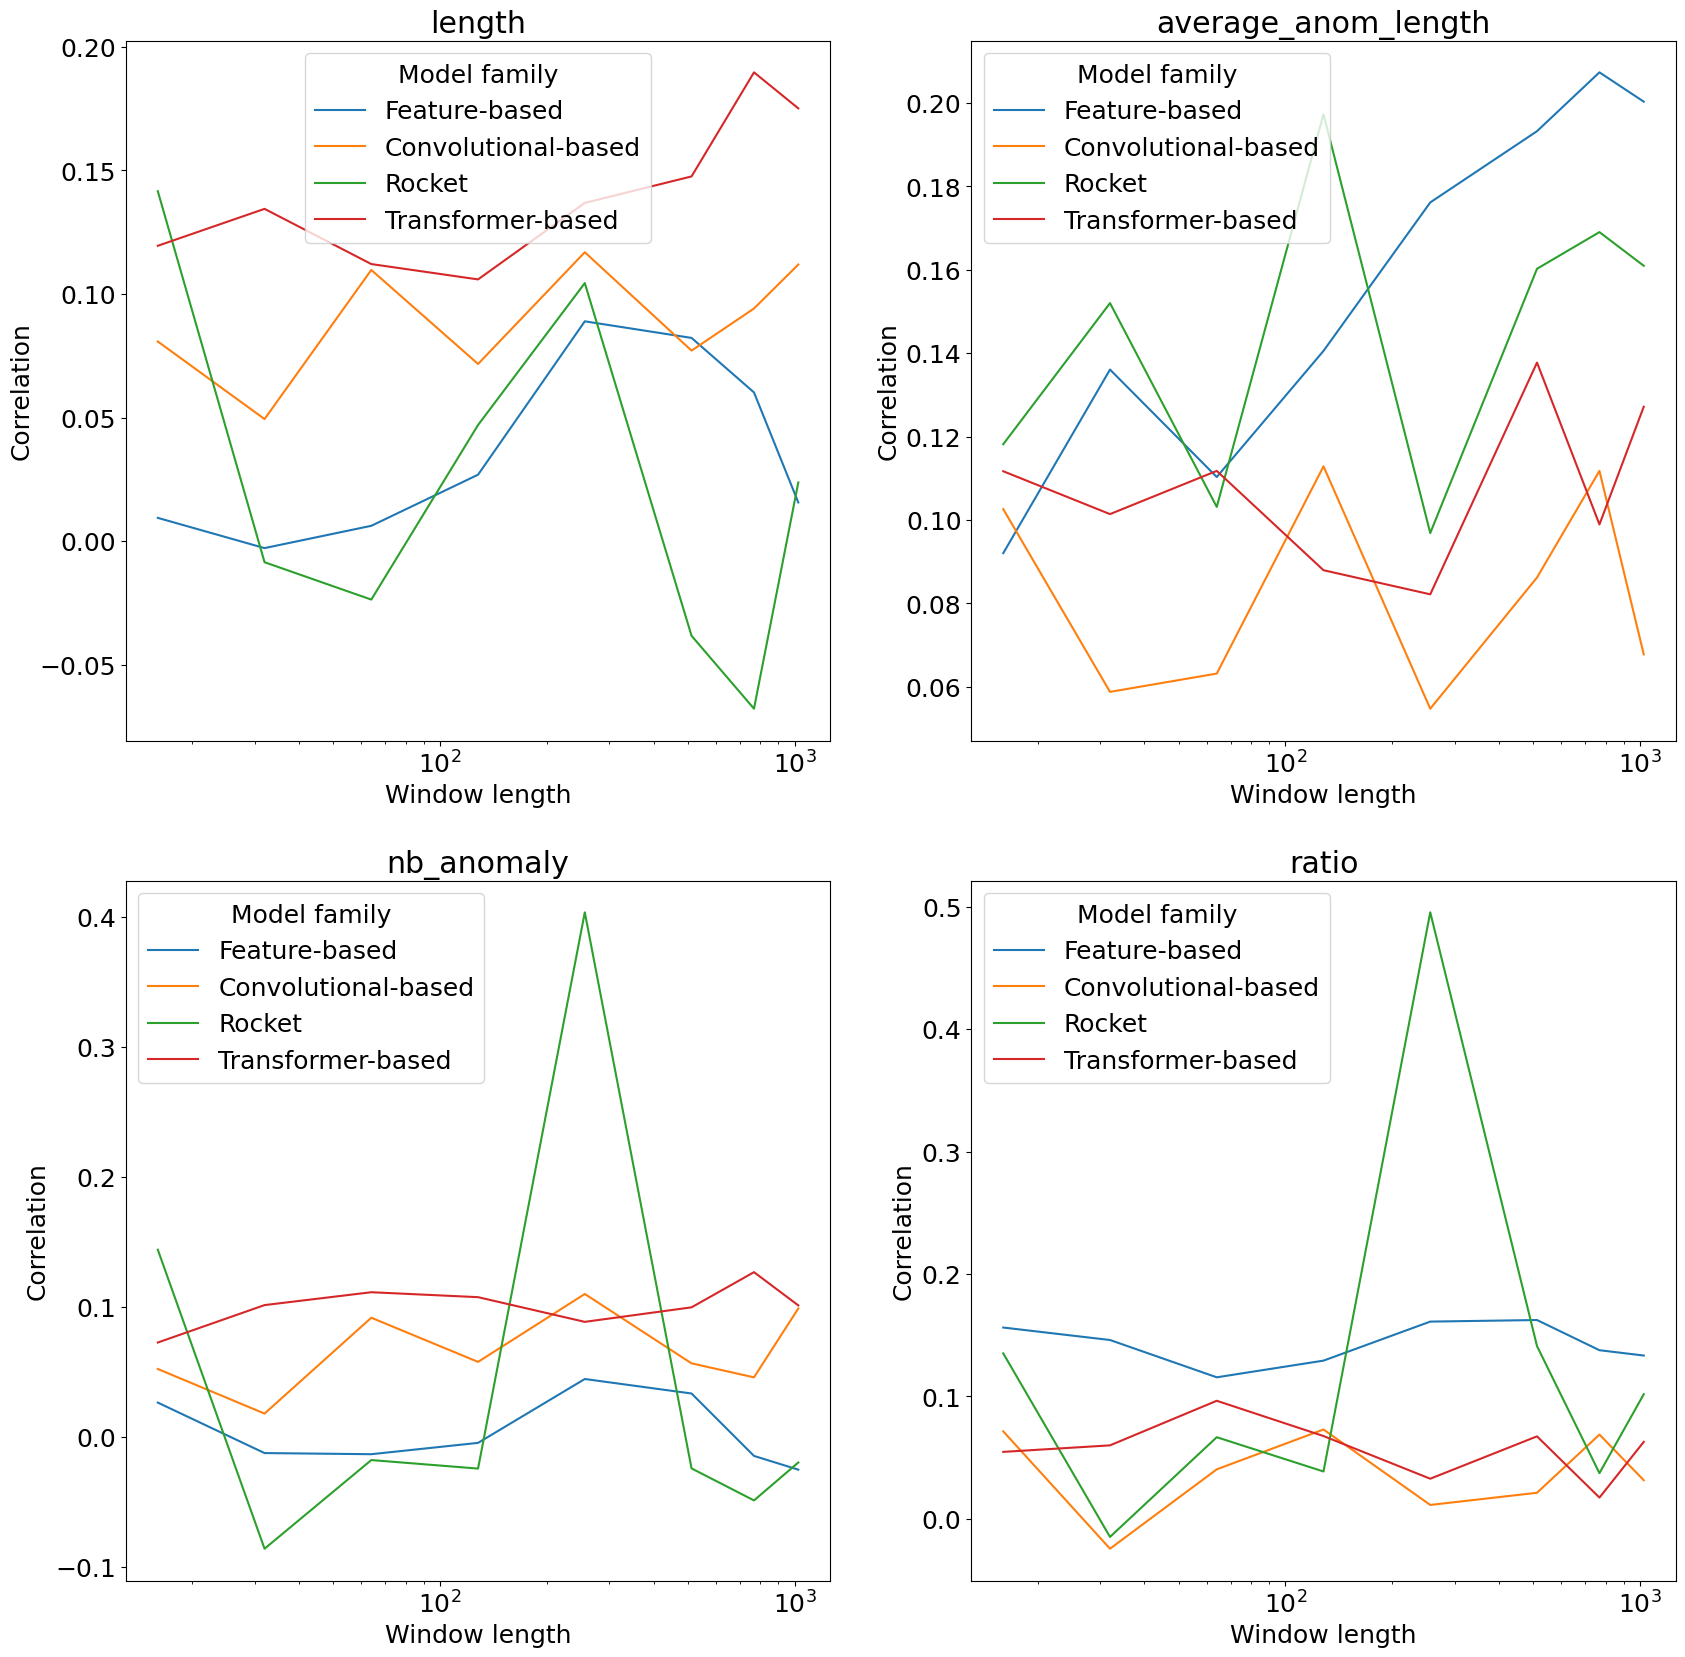

In [54]:
fig, ax = plt.subplots(2, 2, figsize=(20, 20))
errorbar = None

for char, axis in zip(characteristics, ax.flatten()):
    sns.lineplot(
        errorbar = None,
        ax=axis, 
        data=correlations_df[correlations_df['Characteristic'] == char], 
        x='Window length', 
        y='Correlation', 
        hue='Model family'
    )
    axis.set_title(char)
    axis.set_xscale('log')

## Figure 11: Unsupervised results

# Analysis

### Comparing different values of k

In [ ]:
# Plot the effect of k in AUC-PR and compare the different models
fig, axes = plt.subplots(4, 4, figsize=(20, 25), sharey=True)
combine_method = 'vote'

for i in range (0, len(datasets)):
    curr_data = results_df[(results_df["Dataset"] == datasets[i]) & (results_df["Combine Method"] == combine_method)]
    
    sns.lineplot(ax=axes[i//4, i % 4], data=curr_data, x="k", y="AUC-PR", hue="Model Selector", hue_order=model_selectors)

    # Compute average for k = 1
    for j, ms in enumerate(model_selectors):
        curr_avg_k1 = curr_data[(curr_data["Model Selector"] == ms) & (curr_data["k"] == 1)]['AUC-PR'].mean()
        axes[i//4, i % 4].axhline(y=curr_avg_k1, color=f'C{j}', linestyle='dashed', label=f'{ms} k=1')
    
    axes[i//4, i % 4].grid(alpha=0.4)
    axes[i//4, i % 4].title.set_text(datasets[i])
    axes[i//4, i % 4].set_xticks(k_values)

# Compute global plot
curr_data = results_df[(results_df["Combine Method"] == combine_method)]

# Compute average for k = 1
for j, ms in enumerate(model_selectors):
    curr_avg_k1 = curr_data[(curr_data["Model Selector"] == ms) & (curr_data["k"] == 1)]['AUC-PR'].mean()
    axes[3, 3].axhline(y=curr_avg_k1, color=f'C{j}', linestyle='dashed') #, label=f'{ms} k=1'
    
sns.lineplot(ax=axes[3, 3], data=curr_data, x="k", y="AUC-PR", hue="Model Selector", hue_order=model_selectors)
axes[3, 3].grid(alpha=0.4)
axes[3, 3].title.set_text("Global results")
axes[3, 3].set_xticks(k_values)

plt.tight_layout()
plt.show()

In [ ]:
# Plot the effect of k in AUC-PR and compare the different combination methods
fig, axes = plt.subplots(4, 4, figsize=(20, 25), sharey=True)
model_selector = [x for x in model_selectors if 'conv' in x][0]

for i in range (0, len(datasets)):
    curr_data = results_df[(results_df["Dataset"] == datasets[i]) & (results_df["Model Selector"] == model_selector)]

    # Compute average for k = 1
    avg_k_1_average = curr_data[(curr_data["Combine Method"] == 'average') & (curr_data["k"] == 1)]['AUC-PR'].mean()
    avg_k_1_vote = curr_data[(curr_data["Combine Method"] == 'vote') & (curr_data["k"] == 1)]['AUC-PR'].mean()
    
    sns.lineplot(ax=axes[i//4, i % 4], data=curr_data, x="k", y="AUC-PR", hue="Combine Method", hue_order=combine_methods)
    axes[i//4, i % 4].axhline(y=avg_k_1_average, color='C0', linestyle='dashed', label='average k=1')
    axes[i//4, i % 4].axhline(y=avg_k_1_vote, color='C1', linestyle='dotted', label='vote k=1')
    axes[i//4, i % 4].grid(alpha=0.4)
    axes[i//4, i % 4].title.set_text(datasets[i])
    axes[i//4, i % 4].set_xticks(k_values)

# Compute global plot
curr_data = results_df[(results_df["Model Selector"] == model_selector)]

# Compute average for k = 1
avg_k_1_average = curr_data[(curr_data["Combine Method"] == 'average') & (curr_data["k"] == 1)]['AUC-PR'].mean()
avg_k_1_vote = curr_data[(curr_data["Combine Method"] == 'vote') & (curr_data["k"] == 1)]['AUC-PR'].mean()

sns.lineplot(ax=axes[3, 3], data=curr_data, x="k", y="AUC-PR", hue="Combine Method", hue_order=combine_methods)
axes[3, 3].axhline(y=avg_k_1_average, color='C0', linestyle='dashed', label='average k=1')
axes[3, 3].axhline(y=avg_k_1_vote, color='C1', linestyle='dotted', label='vote k=1')
axes[3, 3].grid(alpha=0.4)
axes[3, 3].title.set_text("Global results")
axes[3, 3].set_xticks(k_values)

plt.tight_layout()
plt.show()

In [ ]:
# Compute AVG-ENS average per dataset
avg_ens_means = []
for dataset in datasets:
    avg_ens_means.append({
        "Dataset": dataset,
        "AUC-PR": metrics_df[(metrics_df['Model'] == 'AVG_ENS') & (metrics_df['Dataset'] == dataset)]['AUC-PR'].mean(),
        "VUS-PR": metrics_df[(metrics_df['Model'] == 'AVG_ENS') & (metrics_df['Dataset'] == dataset)]['VUS-PR'].mean(),
    })
avg_ens_means_df = pd.DataFrame(avg_ens_means)
avg_ens_means_df

In [ ]:
# Plot the AUC-PR values in a single plot
fig, axes = plt.subplots(2, 2, figsize=(18, 18), sharey=True)
fig.suptitle("Avg Ens. vs Model Selectors (Supervised)", fontsize=14)

# Calculate the average ensemble median value
avg_ens_mean = avg_ens_means_df['AUC-PR'].mean()

for i, model_selector in enumerate(model_selectors):
    ax = axes[i//2, i%2]
    
    # Compute global plot
    curr_data = results_df[(results_df["Model Selector"] == model_selector) & (results_df["Combine Method"] == "average")]

    # Compute average for k = 1
    avg_k_1_average = curr_data[(curr_data["k"] == 1)]['AUC-PR'].mean()

    # Plot the data
    tmp = sns.lineplot(ax=ax, data=curr_data, x="k", y="AUC-PR")

    max_auc_pr_by_k = curr_data.groupby('k')['AUC-PR'].mean()
    ax.scatter(x=max_auc_pr_by_k.argmax(), y=max_auc_pr_by_k.max(), color='orange', label=f'Max {max_auc_pr_by_k.max():.2f}; k = {max_auc_pr_by_k.argmax()}')
    # ax.scatter(x=max_auc_pr_by_k.argmax(), y=max_auc_pr_by_k.max(), color='orange', label=f'max value')

    # Draw a horizontal line for the avg_ens_median value
    ax.axhline(y=avg_ens_mean, color='red', linestyle='dashed', label=f'AVG-ENS mean: {avg_ens_mean:.2f}')

    # Add horizontal lines for averages
    ax.axhline(y=avg_k_1_average, color='C0', linestyle='dashed', label='k = 1')

    # Customize the plot
    ax.grid(alpha=0.4)
    ax.set_title(f"{model_selector} (Supervised)")
    ax.legend()

plt.tight_layout()
plt.savefig('/home/sylli/Documents/MSAD-E/reports/figures/global_results_average_supervised.svg')
plt.show()

### Evaluating the increase (or decrease) in accuracy

#### Globaly

In [81]:
# Create an empty DataFrame to store the results
global_results = {
    'Model Selector': [], 
    'Combine Method': [],
    'k': [], 
    'Metric': [],
    'Value': [],
}
curr_metric = 'VUS-PR'

# Iterate over each combination of model selector and combine method
for model_selector in model_selectors:
    for combine_method in combine_methods:
        tmp_df = results_df[(results_df["Model Selector"] == model_selector) & (results_df["Combine Method"] == combine_method)]
        curr_k1_avg = tmp_df[tmp_df['k'] == 1][curr_metric].mean()
        
        # Compute the percentage change for each value of k
        for k in k_values:
            curr_k_avg = tmp_df[tmp_df['k'] == k][curr_metric].mean()
            percentage_change = ((curr_k_avg - curr_k1_avg) / curr_k1_avg) * 100

            # Append the result to the DataFrame
            global_results['Model Selector'].append(model_selector)
            global_results['Combine Method'].append(combine_method)
            global_results['k'].append(k)
            # global_results['AUC-PR'].append((np.round(curr_k_avg, 2), np.round(percentage_change, 2)))
            global_results['Metric'].append(curr_metric)
            global_results['Value'].append(curr_k_avg)

            global_results['Model Selector'].append(model_selector)
            global_results['Combine Method'].append(combine_method)
            global_results['k'].append(k)
            global_results['Metric'].append('Percentage change')
            global_results['Value'].append(percentage_change)
                       
global_results_df = pd.DataFrame.from_dict(global_results)

# Print the results DataFrame
global_results_df = global_results_df.pivot(index=["Model Selector", "Combine Method", "Metric"], columns="k", values="Value")
global_results_df.index
s = global_results_df.style.apply(highlight_max, axis=1).format({curr_metric: '{:.3f}', "Percentage change": '{:.1f}'}, na_rep='MISS', precision=3)
s
# print(s.to_latex())

#### Per dataset

In [84]:
# Create an empty DataFrame to store the results
global_results = {
    'Dataset': [],
    'Model Selector': [], 
    'Combine Method': [],
    'k': [], 
    'AUC-PR': []
}

# Iterate over each combination of model selector and combine method
for dataset in datasets:
    for model_selector in model_selectors:
        for combine_method in combine_methods:
            tmp_df = results_df[(results_df["Dataset"] == dataset) & (results_df["Model Selector"] == model_selector) & (results_df["Combine Method"] == combine_method)]
            curr_k1_avg = tmp_df[tmp_df['k'] == 1]['AUC-PR'].mean()
            
            # Compute the percentage change for each value of k
            for k in k_values:
                curr_k_avg = tmp_df[tmp_df['k'] == k]['AUC-PR'].mean()
                percentage_change = ((curr_k_avg - curr_k1_avg) / curr_k1_avg) * 100
    
                # Append the result to the DataFrame
                global_results['Dataset'].append(dataset)
                global_results['Model Selector'].append(model_selector)
                global_results['Combine Method'].append(combine_method)
                global_results['k'].append(k)
                global_results['AUC-PR'].append((np.round(curr_k_avg, 2), np.round(percentage_change, 2)))
                        
global_results_df = pd.DataFrame.from_dict(global_results)

# Print the results DataFrame
global_results_df = global_results_df.pivot(index=["Dataset", "Model Selector", "Combine Method"], columns="k", values="AUC-PR")
global_results_df.style.apply(highlight_max, axis=1)

### k - Probability Plot

In [85]:
# For this experiment we only need the full predicted probabilities
thresh_df = results_df[results_df['k'] == max(k_values)]

# Keep predicted weights of all entries to np array
weight_cols = thresh_df.filter(like="weight")
weight_array = np.array(weight_cols)

# Create dictionary to store data
num_entries = len(thresh_df)
prob_k_plot_data = {
    'k': np.repeat(k_values, num_entries),
    'Probability': np.zeros((len(k_values * num_entries))),
    'Dataset': np.tile(thresh_df['Dataset'].to_numpy(), len(k_values)),
    'AUC-PR': np.tile(thresh_df['AUC-PR'].to_numpy(), len(k_values)),
    'Model Selector': np.tile(thresh_df['Model Selector'].to_numpy(), len(k_values)),
    'Combine Method': np.tile(thresh_df['Combine Method'].to_numpy(), len(k_values)),
}

# Compute cummulative probabilities per sample, per k
for k in tqdm(k_values, desc=f"Computing {k}"):
    for i, weight in enumerate(weight_array):
        curr_sorted_weights = np.sort(weight)[-k:]
        prob_k_plot_data['Probability'][(k-1)*num_entries + i] = curr_sorted_weights.sum()

# Convert dict to DataFrame
prob_k_data_df = pd.DataFrame.from_dict(prob_k_plot_data)
prob_k_data_df['MS - Com. Method'] = prob_k_data_df['Model Selector'] + " - " + prob_k_data_df['Combine Method']
prob_k_data_df

Computing 12: 100%|█████████████████████████████| 12/12 [00:00<00:00, 64.48it/s]


k  Probability      Dataset    AUC-PR Model Selector Combine Method  \
0       1     0.506912         IOPS  0.613582         sit512           vote   
1       1     0.284247         IOPS  0.147880         sit512           vote   
2       1     0.444444         IOPS  0.651273         sit512           vote   
3       1     0.841270         IOPS  0.117926         sit512           vote   
4       1     0.660959         IOPS  0.330488         sit512           vote   
...    ..          ...          ...       ...            ...            ...   
47611  12     1.000000  OPPORTUNITY  0.698896        knn1024           vote   
47612  12     1.000000  OPPORTUNITY  0.768789        knn1024           vote   
47613  12     1.000000  OPPORTUNITY  0.952597        knn1024           vote   
47614  12     1.000000  OPPORTUNITY  0.442192        knn1024           vote   
47615  12     1.000000      Genesis  0.187484         sit512        average   

       MS - Com. Method  
0         sit512 - vote  
1         sit512 - vote  
2         sit512 - vote  
3         sit512 - vote  
4         sit512 - vote  
...                 ...  
47611    knn1024 - vote  
47612    knn1024 - vote  
47613    knn1024 - vote  
47614    knn1024 - vote  
47615  sit512 - average  

[47616 rows x 7 columns]

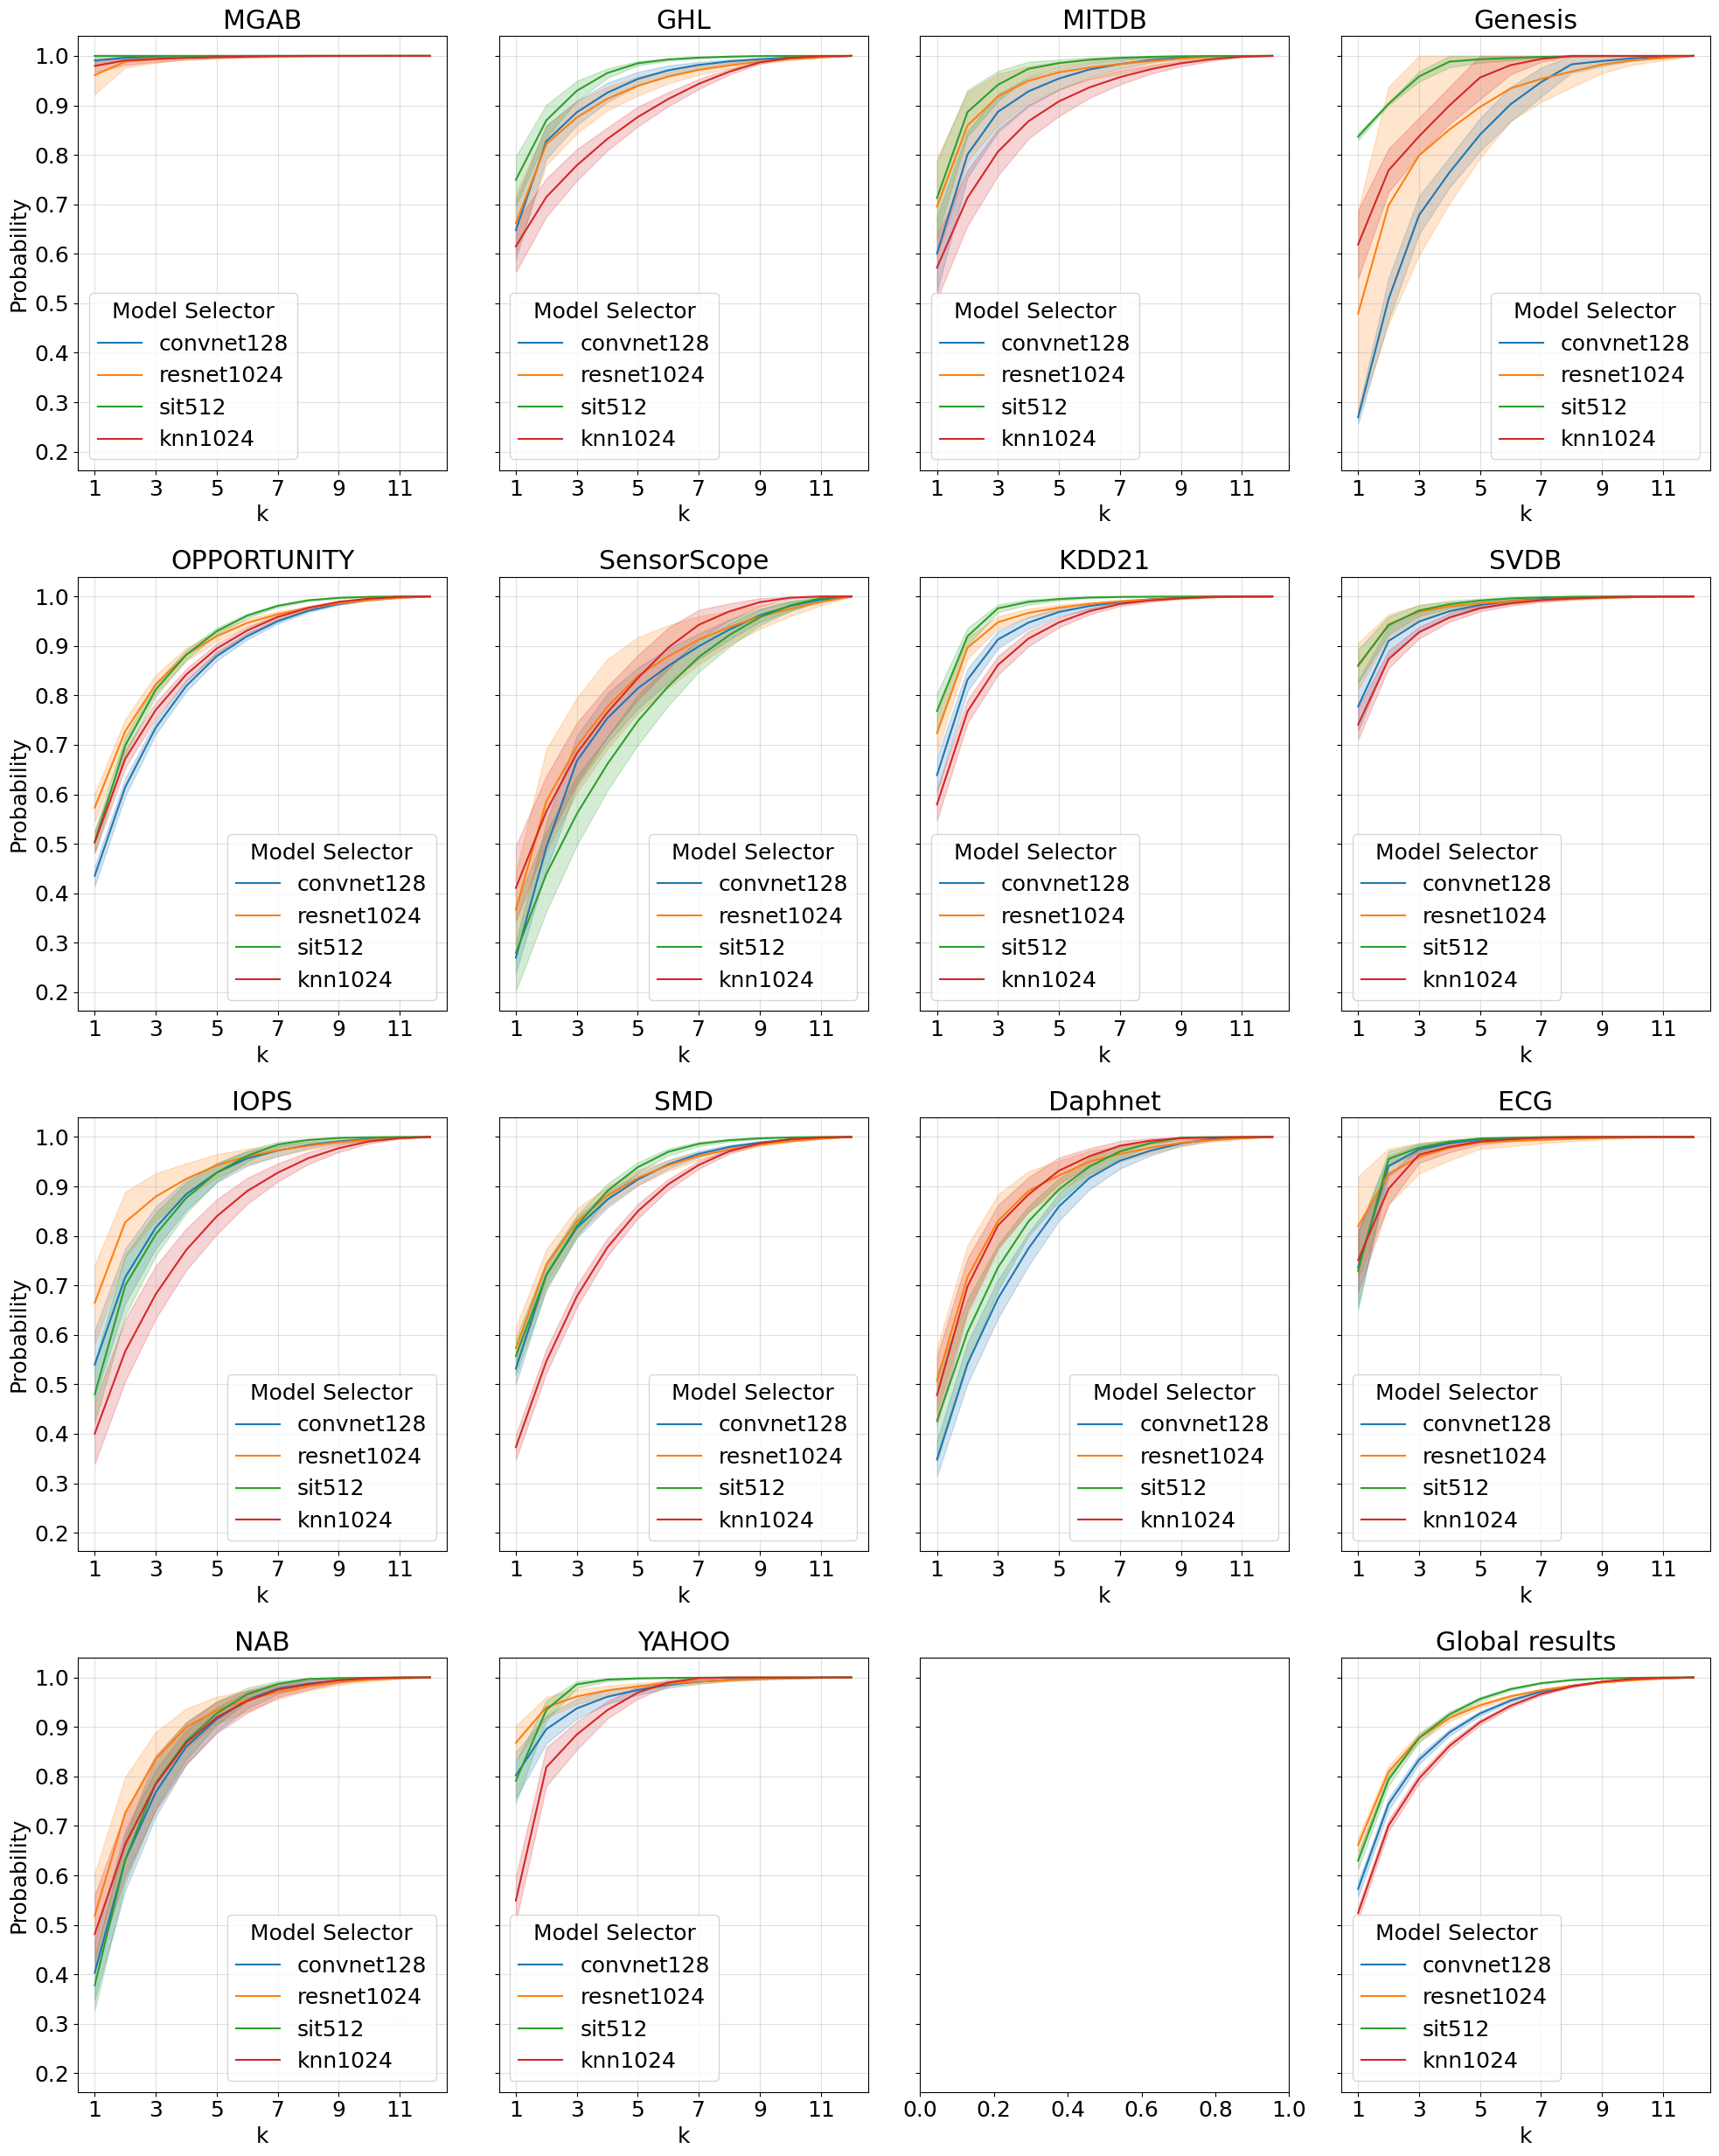

In [87]:
# Plot the AUC-PR values
fig, axes = plt.subplots(4, 4, figsize=(20, 25), sharey=True)

for i, dataset in enumerate(datasets):
    sns.lineplot(ax=axes[i//4, i % 4], data=prob_k_data_df[prob_k_data_df["Dataset"] == dataset], x='k', y='Probability', hue='Model Selector', hue_order=model_selectors)
    axes[i//4, i % 4].grid(alpha=0.4)
    axes[i//4, i % 4].title.set_text(datasets[i])
    axes[i//4, i % 4].set_xticks(range(min(k_values), max(k_values), 2))
    # axes[i//4, i % 4].get_legend().set_visible(False)

sns.lineplot(ax=axes[3, 3], data=prob_k_data_df, x='k', y='Probability', hue='Model Selector', hue_order=model_selectors)
axes[3, 3].grid(alpha=0.4)
axes[3, 3].title.set_text("Global results")
axes[3, 3].set_xticks(range(min(k_values), max(k_values), 2))
# axes[3, 3].get_legend().set_visible(False)

plt.tight_layout()
plt.show()

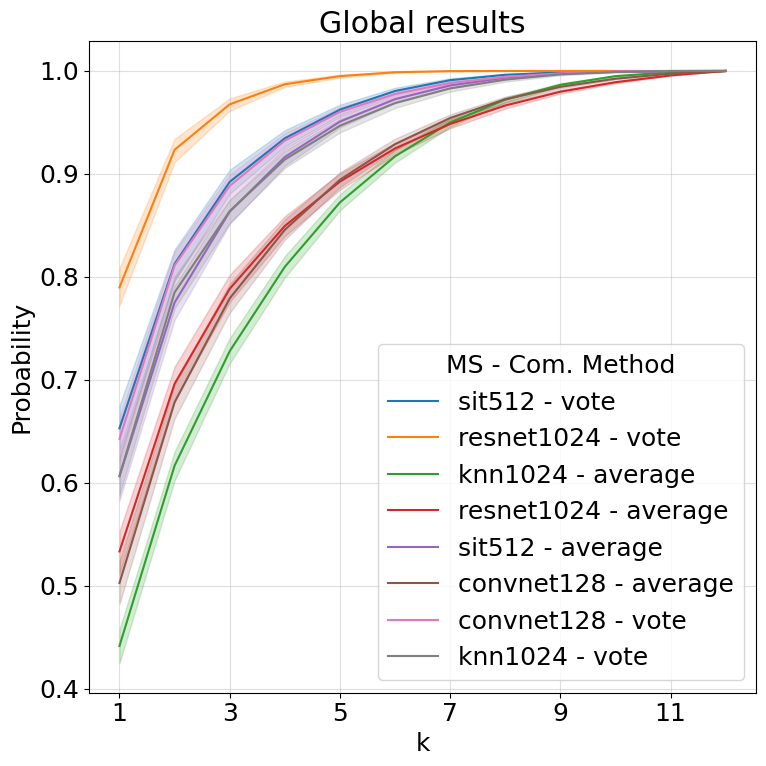

In [91]:
# Plot the AUC-PR values
fig, ax = plt.subplots(figsize=(8, 8))
# hue_order = sorted(list(prob_k_data_df['MS - Com. Method'].unique()))

sns.lineplot(ax=ax, data=prob_k_data_df, x='k', y='Probability', hue='MS - Com. Method')
ax.grid(alpha=0.4)
ax.title.set_text("Global results")
ax.set_xticks(range(min(k_values), max(k_values), 2))

plt.tight_layout()
plt.show()

### Cummulative Probability - AUC-PR Plot

In [92]:
# Filter the DataFrame for maximum 'k'
thresh_df = results_df[results_df['k'] == max(k_values)]

# Pre-compute and store weights for all combinations of 'Time series', 'Model Selector', 'Combine Method'
grouped_weights = thresh_df.groupby(['Time series', 'Model Selector', 'Combine Method'])
sorted_weights = grouped_weights.apply(lambda x: np.sort(x.filter(like="weight").values.flatten())[::-1])

# Initialize the dictionary for storing results
n_entries = len(results_df)
prob_auc_dict = {
    'k': np.array(results_df['k']),
    'Probability': np.zeros(n_entries),
    'Dataset': np.array(results_df['Dataset']),
    'AUC-PR': np.array(results_df['AUC-PR']),
    'Model Selector': np.array(results_df['Model Selector']),
    'Combine Method': np.array(results_df['Combine Method']),
}

# Compute cumulative probabilities per sample, per k
for i, elem in tqdm(enumerate(results_df.iterrows()), desc="Computing Prob - AUC plot", total=len(results_df)):
    index, row = elem
    
    key = (row['Time series'], row['Model Selector'], row['Combine Method'])
    if key in sorted_weights:
        curr_weights = sorted_weights[key]
        curr_cumm_weights = curr_weights[:row['k']]
        # print(index)
        # break
        
        prob_auc_dict['Probability'][i] = curr_cumm_weights.sum()

prob_auc_df = pd.DataFrame.from_dict(prob_auc_dict)
prob_auc_df

/tmp/ipykernel_7947/1972444369.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sorted_weights = grouped_weights.apply(lambda x: np.sort(x.filter(like="weight").values.flatten())[::-1])
Computing Prob - AUC plot: 100%|███████| 47616/47616 [00:04<00:00, 11605.90it/s]


k  Probability      Dataset    AUC-PR Model Selector Combine Method
0      4     0.843318  OPPORTUNITY  0.727534     convnet128           vote
1      4     0.911392  OPPORTUNITY  0.441889     convnet128           vote
2      4     0.845238  OPPORTUNITY  0.905340     convnet128           vote
3      4     0.889552  OPPORTUNITY  0.380968     convnet128           vote
4      4     0.895833  OPPORTUNITY  0.088627     convnet128           vote
...   ..          ...          ...       ...            ...            ...
47611  9     1.000000          GHL  0.006934     convnet128           vote
47612  9     1.000000          GHL  0.009649     convnet128           vote
47613  9     1.000000          GHL  0.000803     convnet128           vote
47614  9     1.000000          GHL  0.121603     convnet128           vote
47615  9     1.000000          GHL  0.006322     convnet128           vote

[47616 rows x 6 columns]

In [93]:
# Define the conditions
conditions = [
    prob_auc_df['Probability'] <= 0.2,  # Up to 0.2
    (prob_auc_df['Probability'] > 0.2) & (prob_auc_df['Probability'] <= 0.4),  # Greater than 0.2 up to 0.4
    (prob_auc_df['Probability'] > 0.4) & (prob_auc_df['Probability'] <= 0.6),  # Greater than 0.4 up to 0.6
    (prob_auc_df['Probability'] > 0.6) & (prob_auc_df['Probability'] <= 0.8),  # Greater than 0.6 up to 0.8
    prob_auc_df['Probability'] > 0.8  # Greater than 0.8
]

# Define the choices, matching the conditions
choices = [
    '0 - 0.2', '0.2 - 0.4', '0.4 - 0.6', '0.6 - 0.8', '0.8 - 1.0'
]

# Apply np.select to create a new column with the categorized data
prob_auc_df['Probability Group'] = np.select(conditions, choices, default='Unknown')

# Show the DataFrame to verify
prob_auc_df

k  Probability      Dataset    AUC-PR Model Selector Combine Method  \
0      4     0.843318  OPPORTUNITY  0.727534     convnet128           vote   
1      4     0.911392  OPPORTUNITY  0.441889     convnet128           vote   
2      4     0.845238  OPPORTUNITY  0.905340     convnet128           vote   
3      4     0.889552  OPPORTUNITY  0.380968     convnet128           vote   
4      4     0.895833  OPPORTUNITY  0.088627     convnet128           vote   
...   ..          ...          ...       ...            ...            ...   
47611  9     1.000000          GHL  0.006934     convnet128           vote   
47612  9     1.000000          GHL  0.009649     convnet128           vote   
47613  9     1.000000          GHL  0.000803     convnet128           vote   
47614  9     1.000000          GHL  0.121603     convnet128           vote   
47615  9     1.000000          GHL  0.006322     convnet128           vote   

      Probability Group  
0             0.8 - 1.0  
1             0.8 - 1.0  
2             0.8 - 1.0  
3             0.8 - 1.0  
4             0.8 - 1.0  
...                 ...  
47611         0.8 - 1.0  
47612         0.8 - 1.0  
47613         0.8 - 1.0  
47614         0.8 - 1.0  
47615         0.8 - 1.0  

[47616 rows x 7 columns]

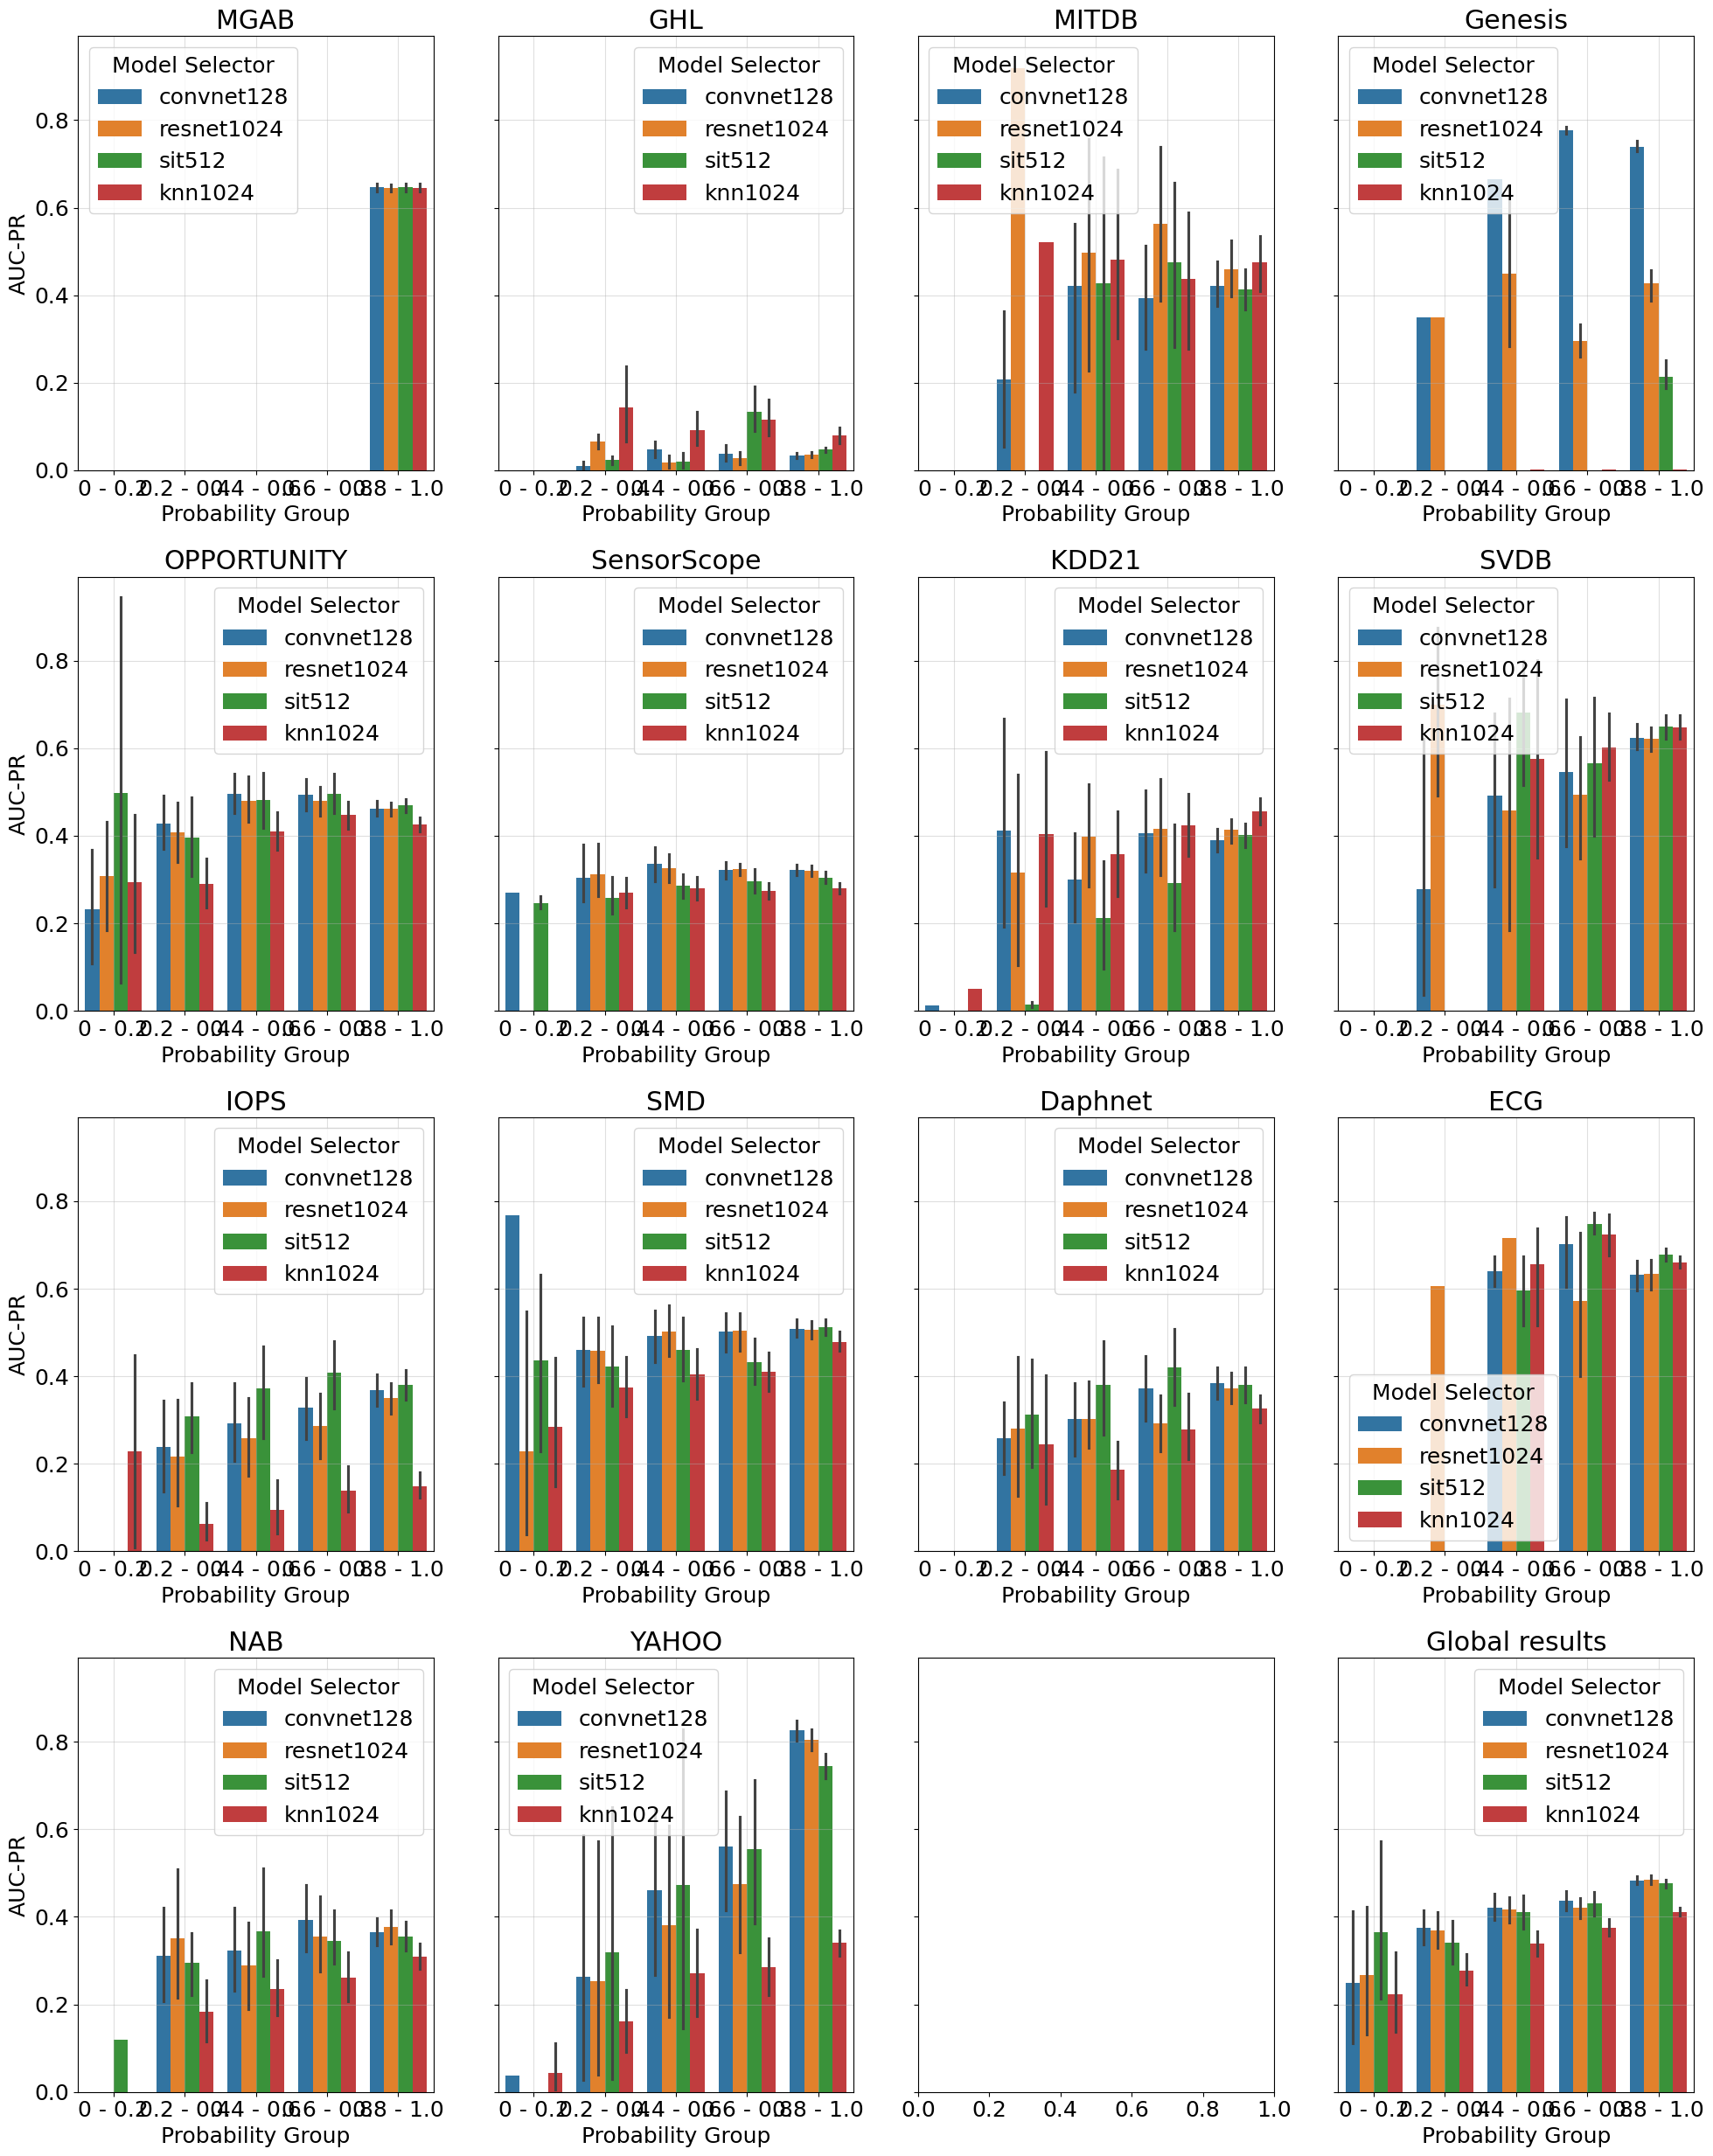

In [97]:
# Plot the AUC-PR values
fig, axes = plt.subplots(4, 4, figsize=(20, 25), sharey=True)
tmp_prob_auc_df = prob_auc_df[prob_auc_df['Combine Method'] == 'average']

for i, dataset in enumerate(datasets):
    sns.barplot(ax=axes[i//4, i % 4], data=tmp_prob_auc_df[tmp_prob_auc_df["Dataset"] == dataset], x='Probability Group', y='AUC-PR', hue='Model Selector', order=choices, hue_order=model_selectors)
    axes[i//4, i % 4].grid(alpha=0.4)
    axes[i//4, i % 4].title.set_text(datasets[i])

sns.barplot(ax=axes[3, 3], data=tmp_prob_auc_df, x='Probability Group', y='AUC-PR', hue='Model Selector', order=choices, hue_order=model_selectors)
axes[3, 3].grid(alpha=0.4)
axes[3, 3].title.set_text("Global results")

plt.tight_layout()
plt.show()

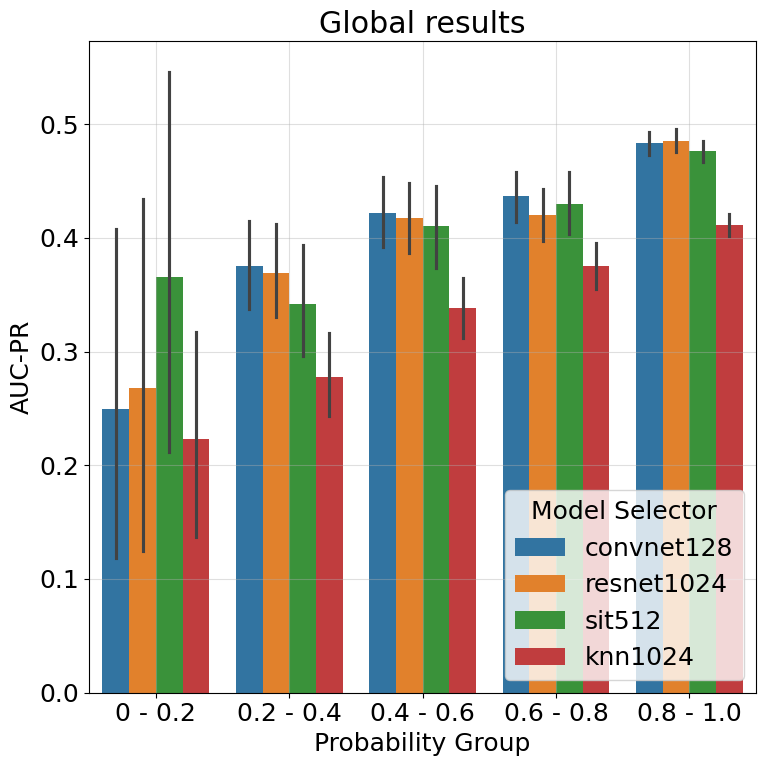

In [98]:
# Plot the AUC-PR values
fig, ax = plt.subplots(figsize=(8, 8))

sns.barplot(ax=ax, data=tmp_prob_auc_df, x='Probability Group', y='AUC-PR', hue='Model Selector', order=choices, hue_order=model_selectors)
ax.grid(alpha=0.4)
ax.title.set_text("Global results")

plt.tight_layout()
plt.show()

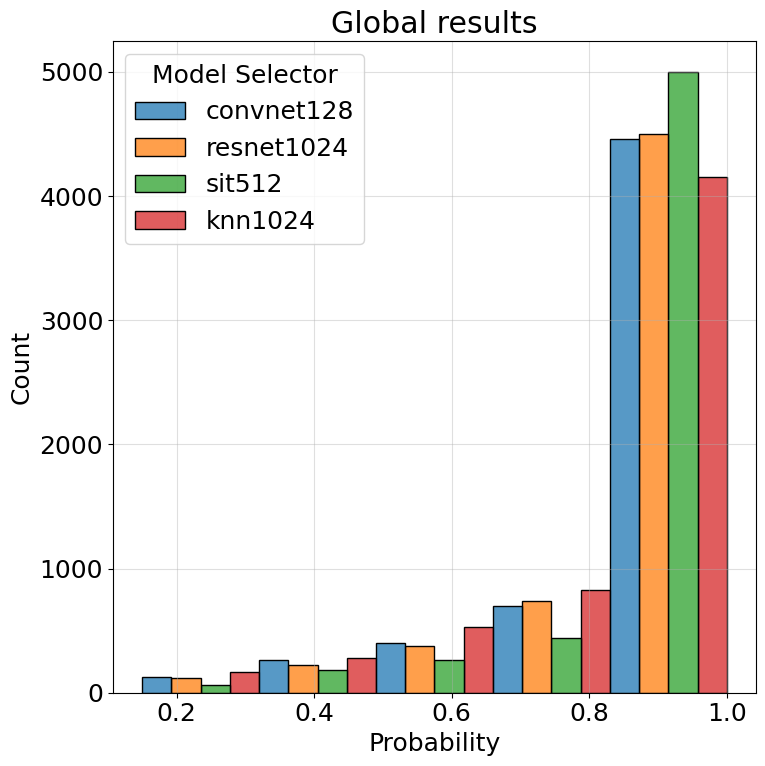

In [99]:
# Plot the AUC-PR values
fig, ax = plt.subplots(figsize=(8, 8))

sns.histplot(ax=ax, data=tmp_prob_auc_df, x='Probability', hue='Model Selector', multiple="dodge", bins=len(choices), hue_order=model_selectors)
ax.grid(alpha=0.4)
ax.title.set_text("Global results")

plt.tight_layout()
plt.show()